In [1]:
import numpy as np         # para fazer contas e mexer com matrizes
import pandas as pd        # para montar DataFrames (tabelas de bancos de dados)

import matplotlib.pyplot as plt

import modelos as m

# CUIDADO!!! Para esconder os avisos do curvefit():
import warnings
warnings.filterwarnings("ignore")

In [2]:
# onde ele procura por bibliotecas
#import sys
#sys.path.append('/dados/github/projetos/recrutabilidade/volume_referencia') # como último
#sys.path.insert(0,'/dados/github/projetos/recrutabilidade/volume_referencia') # como primeiro
#sys.path # ele procura na ordem que aparece...

# carregando uma biblioteca de outra pasta:
#import ctFuncs as ctff2

In [3]:
# para não precisar reiniciar o kernel do jupyter-notebook quando mudar os arquivos .py
%load_ext autoreload
%autoreload 2

# Lendo dados

In [4]:
dadosdf = m.carrega_pickles()

Lendo porquinho_mra33.pickle			
Lendo porquinho_mra26.pickle			
Lendo porquinho_mra32.pickle			
Lendo porquinho_mra29.pickle			
Lendo porquinho_mra34.pickle			
Lendo porquinho_mra28.pickle			
Lendo porquinho_mra31.pickle			


In [5]:
#dadosdf.head(4)
dadosdf.tail(4)

,Animal,Manobra,Dados,n_steps,Pressoes,Volumes,volume_esperado
17,mra28,D,"[[10.240625381469727, -179.3195037841797], [20...",5,"[10.240625381469727, 14.828125, 20.05937480926...","[-179.3195037841797, -62.187042236328125, 182....",0
18,mra31,D,"[[10.0, -107.7169418334961], [20.2000007629394...",5,"[10.0, 15.0, 20.100000381469727, 24.8999996185...","[-107.7169418334961, 47.35507583618164, 235.19...",0
19,mra31,B,"[[10.300000190734863, -25.01786231994629], [20...",3,"[10.300000190734863, 15.100000381469727, 19.89...","[-25.01786231994629, 122.25248718261719, 244.6...",0
20,mra31,C,"[[9.699999809265137, -228.3211212158203], [20....",4,"[9.699999809265137, 15.300000190734863, 20.100...","[-228.3211212158203, -71.18547058105469, 125.5...",0


In [6]:
# Separa só manobra D, com 5 passos, sem guardar índice original da tabela
dadosdfD5 = dadosdf[dadosdf["n_steps"]==5].reset_index(drop=True)
dadosdfD5

,Animal,Manobra,Dados,n_steps,Pressoes,Volumes,volume_esperado
0,mra33,D,"[[10.312239646911621, -75.62246704101562], [20...",5,"[10.312239646911621, 14.991406440734863, 20.00...","[-75.62246704101562, 107.81485748291016, 363.4...",0
1,mra26,D,"[[10.178125381469727, -197.8517303466797], [20...",5,"[10.178125381469727, 15.212499618530273, 20.42...","[-197.8517303466797, -95.13343811035156, 97.13...",0
2,mra32,D,"[[10.625260829925537, -53.54884338378906], [20...",5,"[10.625260829925537, 15.398958206176758, 20.37...","[-53.54884338378906, 33.332923889160156, 174.5...",0
3,mra29,D,"[[10.286250114440918, -210.43722534179688], [2...",5,"[10.286250114440918, 15.094120502471924, 19.99...","[-210.43722534179688, -118.89096069335938, 33....",0
4,mra34,D,"[[9.9609375, -167.6243133544922], [20.25208377...",5,"[9.9609375, 15.040364742279053, 20.13463592529...","[-167.6243133544922, 13.06080150604248, 203.19...",0
5,mra28,D,"[[10.240625381469727, -179.3195037841797], [20...",5,"[10.240625381469727, 14.828125, 20.05937480926...","[-179.3195037841797, -62.187042236328125, 182....",0
6,mra31,D,"[[10.0, -107.7169418334961], [20.2000007629394...",5,"[10.0, 15.0, 20.100000381469727, 24.8999996185...","[-107.7169418334961, 47.35507583618164, 235.19...",0


# Teste dos modelos

## Incluindo volume esperado no DataFrame

Volumes esperados:

* MRA26: 2622.9 mL; K = 0.0309
* MRA28: 2105.9 mL; K = 0.0447
* MRA29: 2205.7 mL; K = 0.0596
* MRA31: 1974.4 mL; K = 0.0619
* MRA32: 1440.2 mL; K = 0.0476
* MRA33: 2154.6 mL; K = 0.0634
* MRA34: ?

In [7]:
v_esperado = {
    "mra26": 2622.9,
    "mra28": 2105.9,
    "mra29": 2205.7,
    "mra31": 1974.4,
    "mra32": 1440.2,
    "mra33": 2154.6,
    "mra34": 2600 # chute
}

In [8]:
v_esperado['mra34']

2600

In [9]:
dadosdfD5.iloc[0].Animal

'mra33'

In [10]:
dadosdfD5["volume_esperado"] = dadosdfD5.apply(lambda row: v_esperado[row.Animal], axis=1)

In [11]:
dadosdfD5.head(3)

,Animal,Manobra,Dados,n_steps,Pressoes,Volumes,volume_esperado
0,mra33,D,"[[10.312239646911621, -75.62246704101562], [20...",5,"[10.312239646911621, 14.991406440734863, 20.00...","[-75.62246704101562, 107.81485748291016, 363.4...",2154.6
1,mra26,D,"[[10.178125381469727, -197.8517303466797], [20...",5,"[10.178125381469727, 15.212499618530273, 20.42...","[-197.8517303466797, -95.13343811035156, 97.13...",2622.9
2,mra32,D,"[[10.625260829925537, -53.54884338378906], [20...",5,"[10.625260829925537, 15.398958206176758, 20.37...","[-53.54884338378906, 33.332923889160156, 174.5...",1440.2


## Testando modelos

### sigmoid_recruit_units

In [12]:
# sigmoid_recruit_units:            K, Vmax, mi, sigma, offset
sigmoid_recruit_units_bounds = ([0.02,  500,  0,     2,   -500],
                                [0.08, 3500, 40,    40,    500])
sigmoid_recruit_units_p0 =      [0.05, 2000, 25,     5,   -200]
debug=True
metodo = 'dogbox'

#### Com limites, sem interpolar

Testando caso 0: mra33: [0.080  3500.0    33.0    15.7  -240.8 ]
Testando caso 1: mra26: [0.080  1855.9    28.6    10.6  -249.7 ]
Testando caso 2: mra32: [0.020  1124.7    16.6     6.3   -93.7 ]
Testando caso 3: mra29: [0.080   989.9    22.8     6.6  -225.0 ]
Testando caso 4: mra34: [0.080  3500.0    37.6    18.3  -307.5 ]
Testando caso 5: mra28: [0.020  2439.4    19.6     7.8  -237.9 ]
Testando caso 6: mra31: [0.080  1041.9    18.2    10.2  -235.9 ]


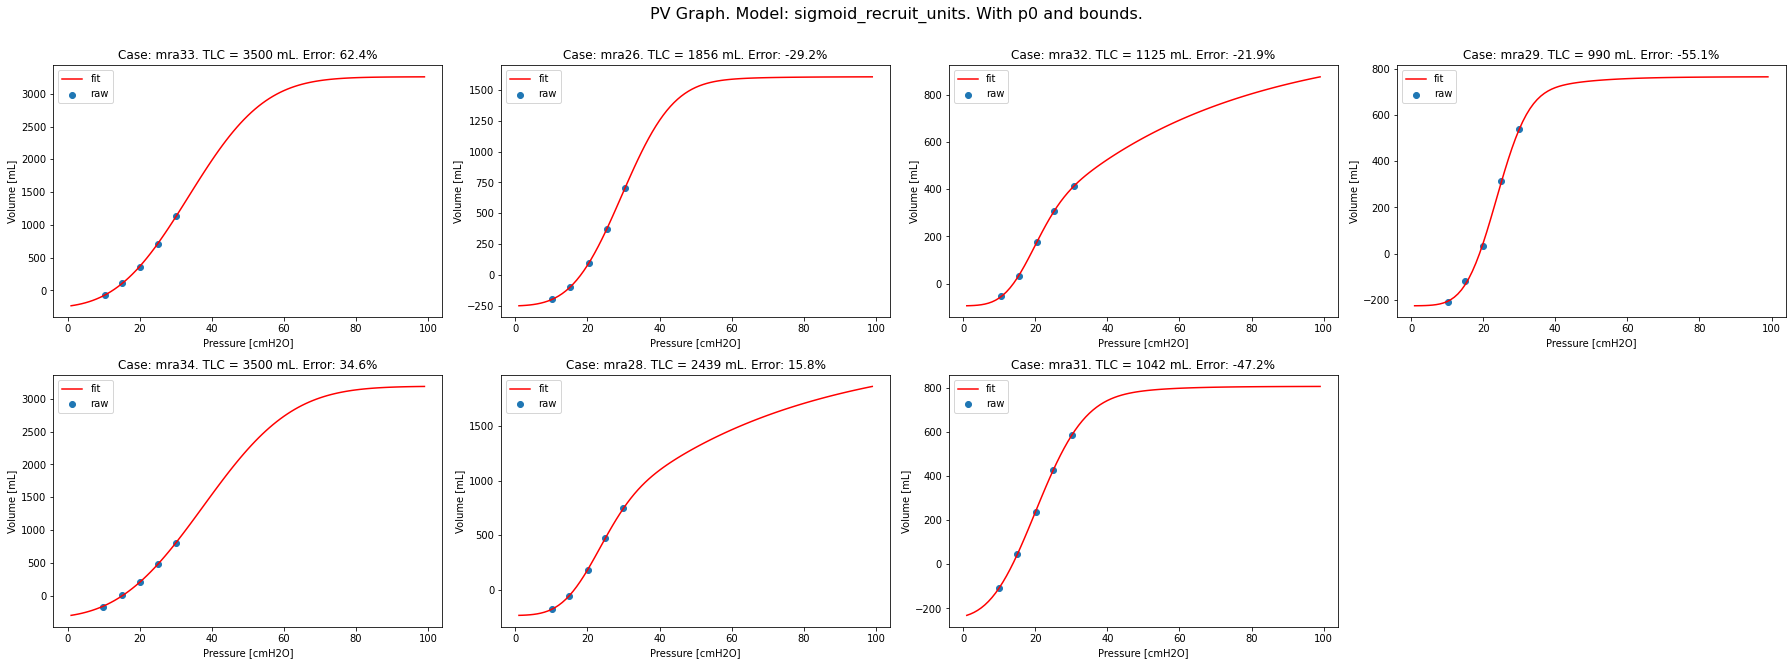

Norma(erro): 109.3. Erro médio: 38.06%. Ajustados: 7.


In [13]:
n_points_interp = 0
texto = 'With p0 and bounds.'
_= m.testa_modelo(dadosdfD5, m.sigmoid_recruit_units, metodo = metodo, meu_p0 = sigmoid_recruit_units_p0, texto = texto, TLC_index=1, meus_bounds=sigmoid_recruit_units_bounds, n_points_interp=n_points_interp, debug=debug)

#### Com limites, interpolando

Testando caso 0: mra33: [0.080  3500.0    33.1    15.7  -234.5 ]
Testando caso 1: mra26: [0.080  1847.3    28.6    10.6  -248.0 ]
Testando caso 2: mra32: [0.020  1128.6    16.6     6.4   -95.1 ]
Testando caso 3: mra29: [0.080   973.0    22.9     6.3  -213.1 ]
Testando caso 4: mra34: [0.080  3500.0    37.7    18.0  -289.8 ]
Testando caso 5: mra28: [0.020  2443.7    19.6     7.9  -239.6 ]
Testando caso 6: mra31: [0.080  1043.9    18.4    10.2  -231.0 ]


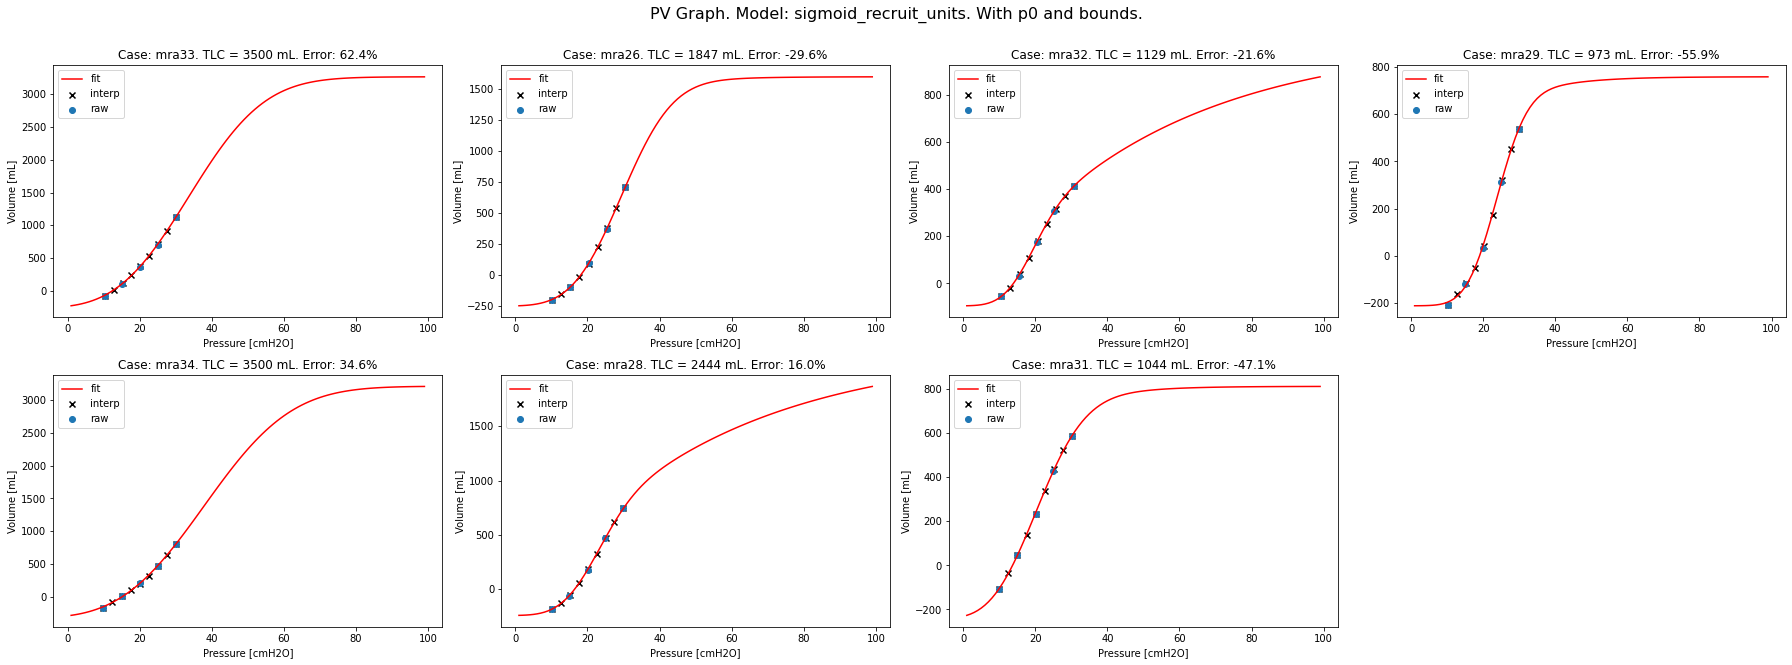

Norma(erro): 109.7. Erro médio: 38.19%. Ajustados: 7.


In [14]:
n_points_interp = 1
texto = 'With p0 and bounds.'
_= m.testa_modelo(dadosdfD5, m.sigmoid_recruit_units, metodo = metodo, meu_p0 = sigmoid_recruit_units_p0, texto = texto, TLC_index=1, meus_bounds=sigmoid_recruit_units_bounds, n_points_interp=n_points_interp, debug=debug)

#### Sem limites

	Caso 0 (mra33) deu erro...
Testando caso 1: mra26: [    7.4  1754.6    29.1     9.9  -259.3 ]
Testando caso 2: mra32: [    2.3   588.2    20.5     7.5  -118.6 ]
	Caso 3 (mra29) deu erro...
	Caso 4 (mra34) deu erro...
Testando caso 5: mra28: [    2.8  1303.9    23.7     8.1  -258.0 ]
Testando caso 6: mra31: [   11.0  1035.0    20.3     9.8  -270.7 ]


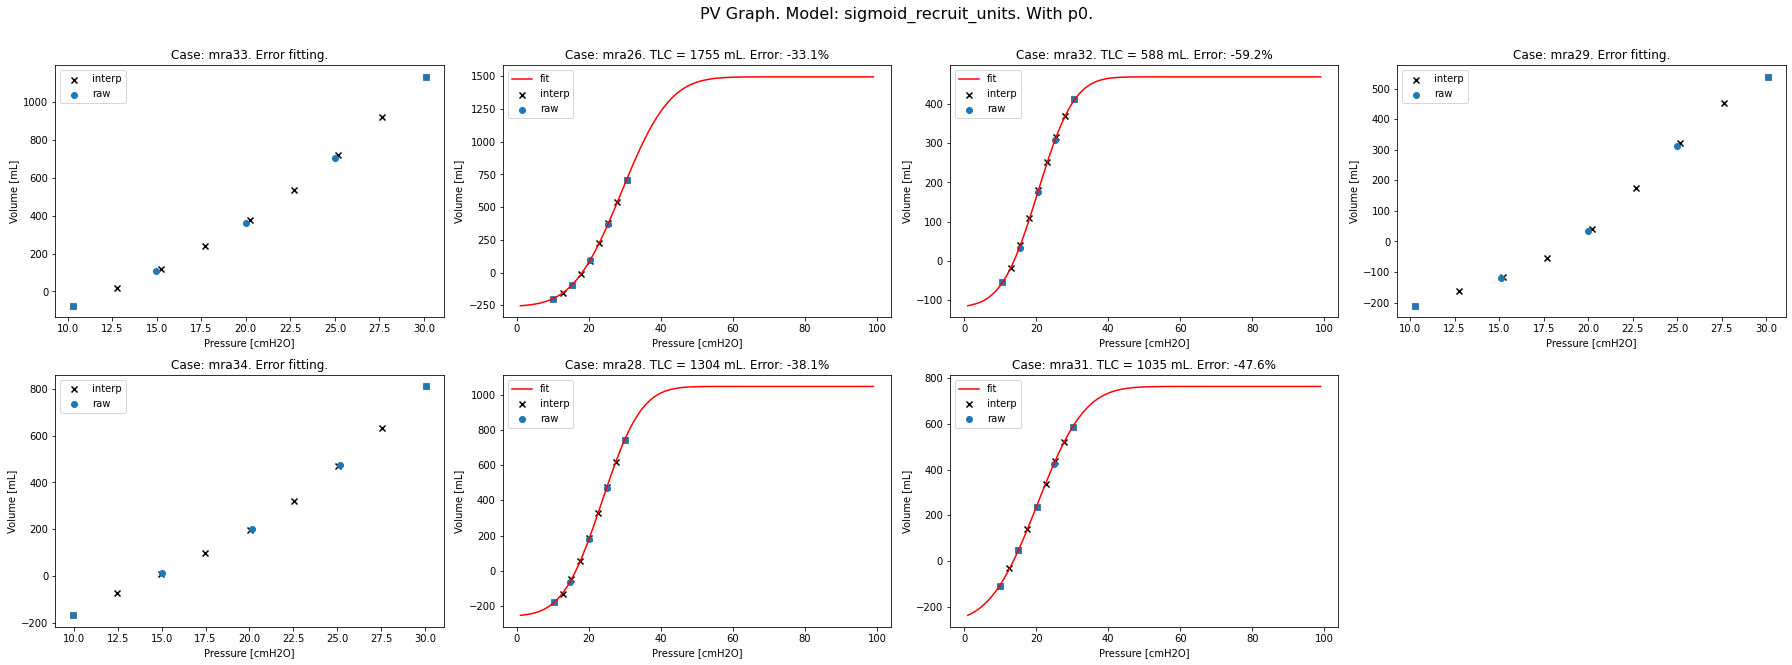

Norma(erro): 91.2. Erro médio: 44.48%. Ajustados: 4.


In [15]:
n_points_interp = 1
texto = 'With p0.'
_= m.testa_modelo(dadosdfD5, m.sigmoid_recruit_units, metodo = metodo, meu_p0 = sigmoid_recruit_units_p0, texto = texto, TLC_index=1, n_points_interp=n_points_interp, debug=debug)

### sigmoidvenegas1

In [16]:
# sigmoidvenegas1: (a, b, c, d): a + b/(1 + np.exp(-(x-c)/d))
#          offset, Vmax, 'mi', 'sigma'   
bounds = ([  -500,  500,    0,      2],
          [   500, 3500,   40,     40])
p0 =      [  -200, 2000,   25,      5]
TLC_index = 1
metodo = 'trf'
modelo = m.sigmoidvenegas1
debug = True

#### Com limites, sem interpolar

Testando caso 0: mra34: [ -481.1  3500.0    36.3    11.5 ]
Testando caso 1: mra28: [ -297.5  1384.2    23.7     5.6 ]
Testando caso 2: mra31: [ -327.8  1137.7    20.1     7.1 ]
Testando caso 3: mra32: [ -139.8   634.8    20.6     5.3 ]
Testando caso 4: mra26: [ -294.7  1695.6    28.1     6.4 ]
Testando caso 5: mra29: [ -247.6   968.3    23.7     4.3 ]
Testando caso 6: mra33: [ -413.4  3500.0    32.5     9.9 ]


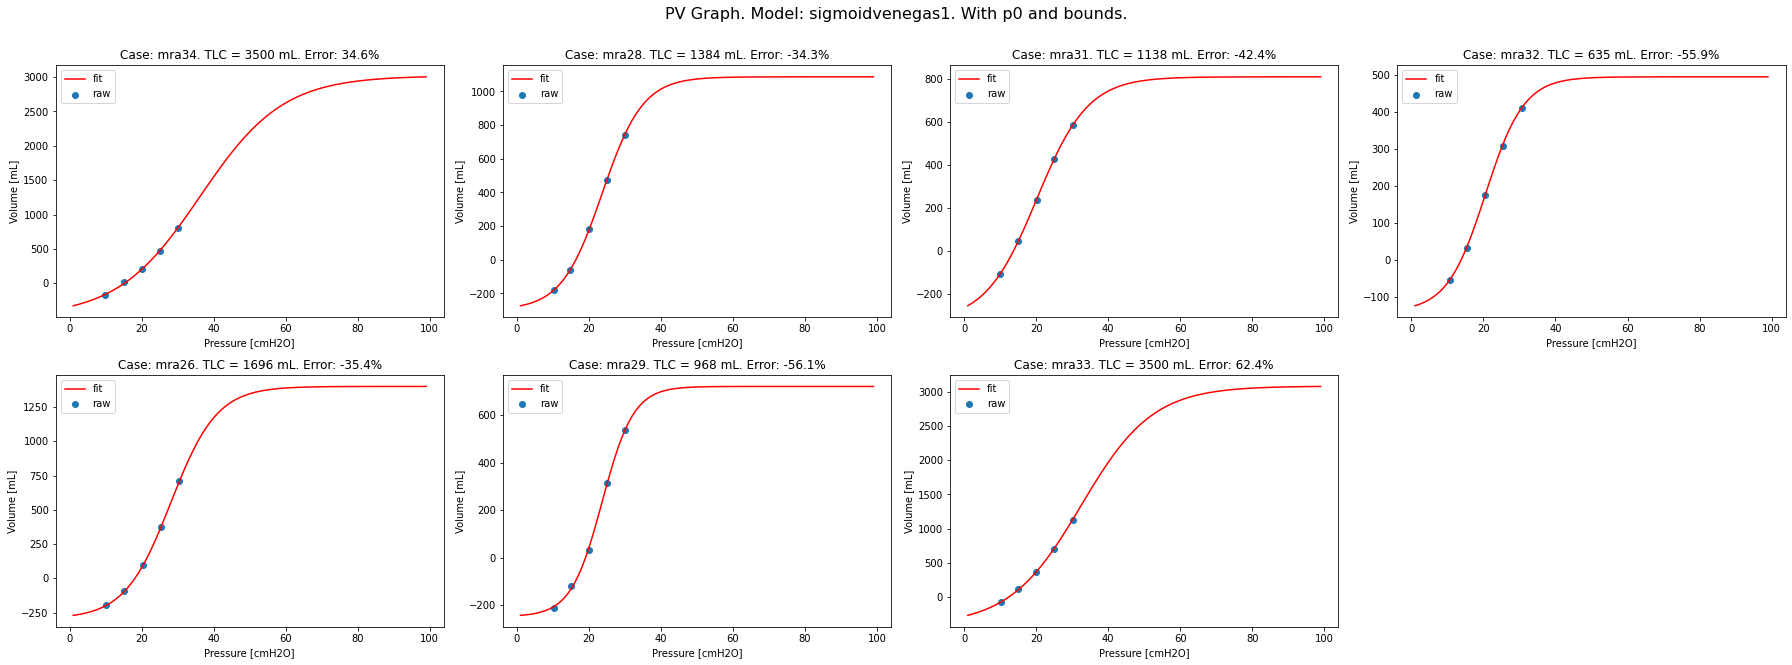

Norma(erro): 124.9. Erro médio: 45.87%. Ajustados: 7.


(124.86707629541543, 45.868533599713196, 7)

Testando caso 0: mra33: [ -413.4  3500.0    32.5     9.9 ]
Testando caso 1: mra26: [ -294.7  1695.6    28.1     6.4 ]
Testando caso 2: mra32: [ -139.8   634.8    20.6     5.3 ]
Testando caso 3: mra29: [ -247.6   968.3    23.7     4.3 ]
Testando caso 4: mra34: [ -481.1  3500.0    36.3    11.5 ]
Testando caso 5: mra28: [ -297.5  1384.2    23.7     5.6 ]
Testando caso 6: mra31: [ -327.8  1137.7    20.1     7.1 ]


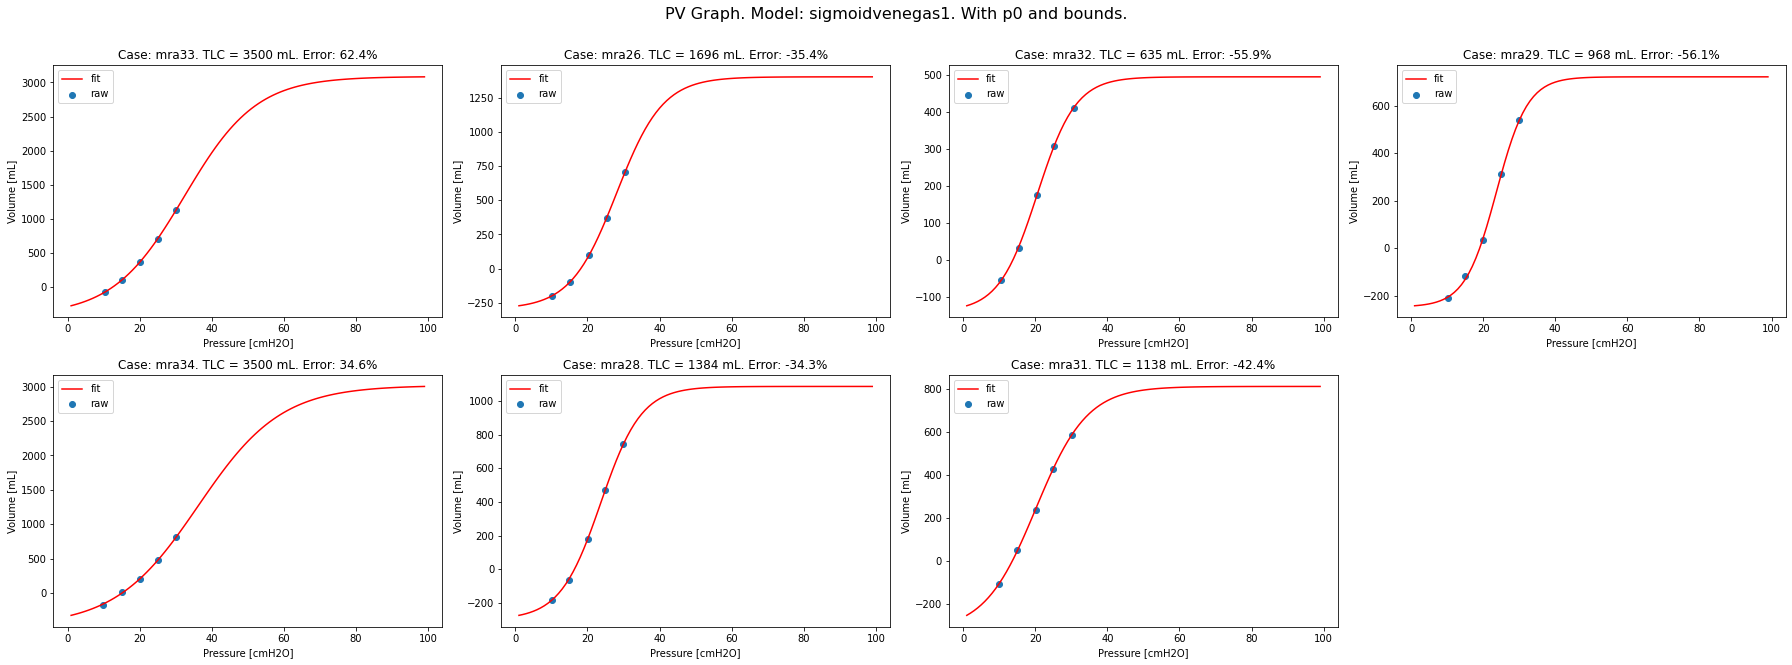

In [17]:
n_points_interp = 0
texto = 'With p0 and bounds.'
m.testa_modelo(dadosdfD5, modelo, metodo = metodo, meu_p0 = p0, texto = texto, TLC_index=TLC_index, meus_bounds=bounds, n_points_interp=n_points_interp, debug=debug)

#### Com limites, interpolando

Testando caso 0: mra34: [ -421.3  3500.0    36.8    11.0 ]
Testando caso 1: mra28: [ -313.4  1411.2    23.6     5.8 ]
Testando caso 2: mra31: [ -318.6  1150.5    20.6     7.2 ]
Testando caso 3: mra32: [ -154.1   651.6    20.3     5.5 ]
Testando caso 4: mra26: [ -295.4  1692.1    28.1     6.4 ]
Testando caso 5: mra29: [ -226.1   947.9    23.9     4.1 ]
Testando caso 6: mra33: [ -399.5  3500.0    32.6     9.9 ]


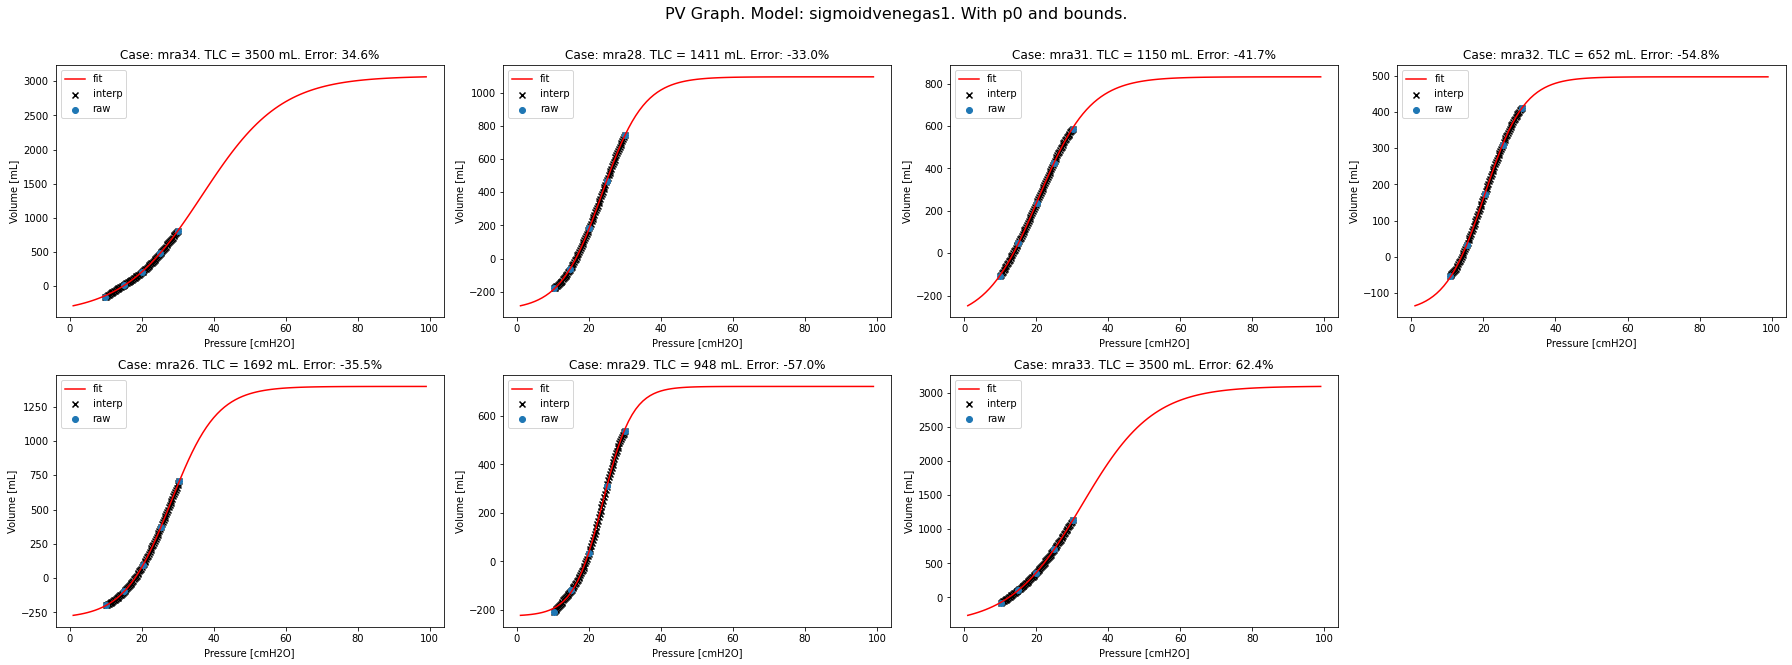

Norma(erro): 124.2. Erro médio: 45.58%. Ajustados: 7.


(124.24293952070634, 45.57782545949262, 7)

Testando caso 0: mra33: [ -399.5  3500.0    32.6     9.9 ]
Testando caso 1: mra26: [ -295.4  1692.1    28.1     6.4 ]
Testando caso 2: mra32: [ -154.1   651.6    20.3     5.5 ]
Testando caso 3: mra29: [ -226.1   947.9    23.9     4.1 ]
Testando caso 4: mra34: [ -421.3  3500.0    36.8    11.0 ]
Testando caso 5: mra28: [ -313.4  1411.2    23.6     5.8 ]
Testando caso 6: mra31: [ -318.6  1150.5    20.6     7.2 ]


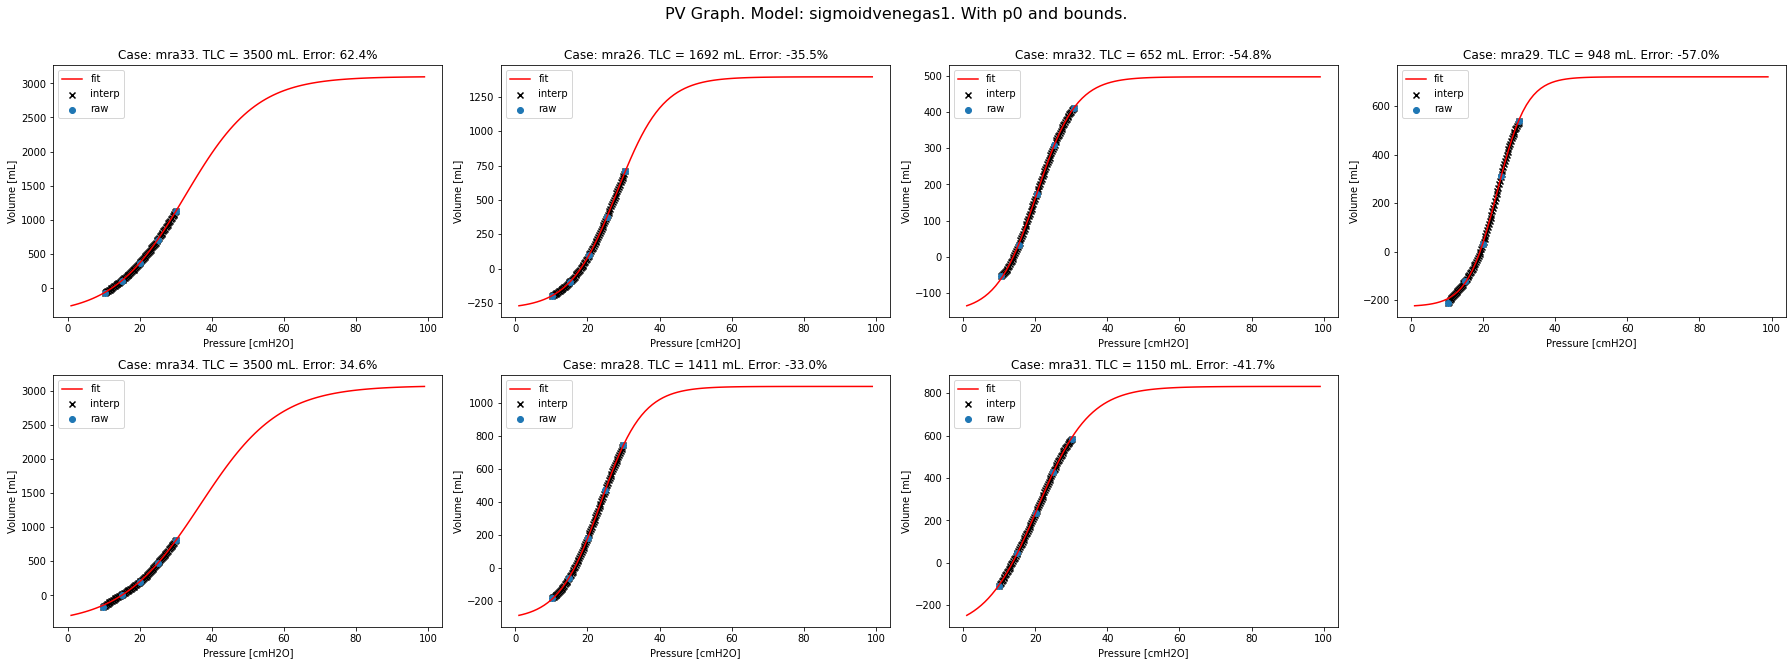

In [18]:
n_points_interp = 20
texto = 'With p0 and bounds.'
m.testa_modelo(dadosdfD5, modelo, metodo = metodo, meu_p0 = p0, texto = texto, TLC_index=TLC_index, meus_bounds=bounds, n_points_interp=n_points_interp, debug=debug)

#### Sem limites

	Caso 0 (mra34) deu erro...
Testando caso 1: mra28: [ -313.4  1411.2    23.6     5.8 ]
Testando caso 2: mra31: [ -318.6  1150.5    20.6     7.2 ]
Testando caso 3: mra32: [ -154.1   651.6    20.3     5.5 ]
Testando caso 4: mra26: [ -295.4  1692.1    28.1     6.4 ]
Testando caso 5: mra29: [ -226.1   947.9    23.9     4.1 ]
Testando caso 6: mra33: [ -463.9  4402.3    36.4    11.2 ]


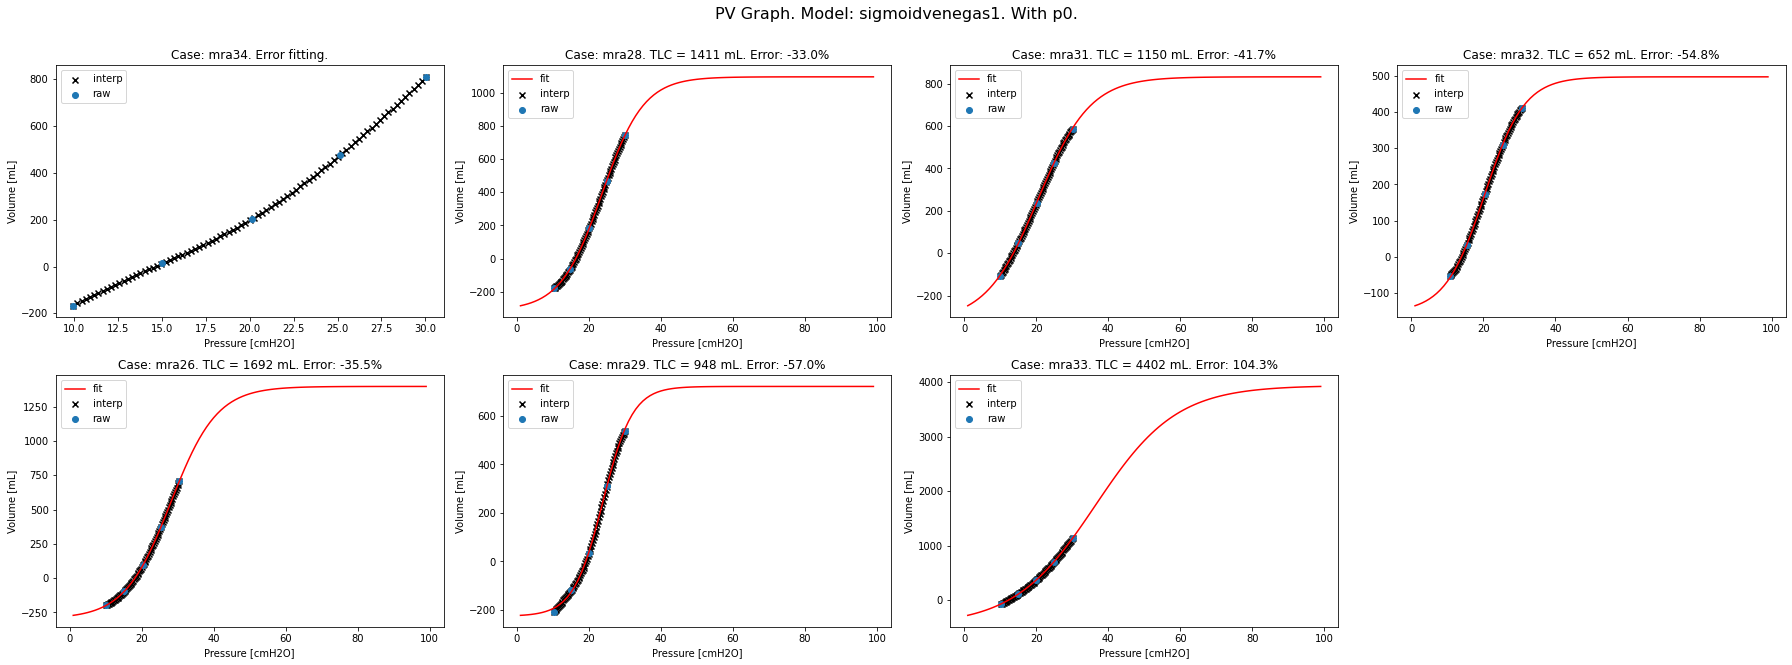

Norma(erro): 145.7. Erro médio: 54.38%. Ajustados: 6.


(145.6781009865968, 54.38478232265775, 6)

Testando caso 0: mra33: [ -463.9  4402.3    36.4    11.2 ]
Testando caso 1: mra26: [ -295.4  1692.1    28.1     6.4 ]
Testando caso 2: mra32: [ -154.1   651.6    20.3     5.5 ]
Testando caso 3: mra29: [ -226.1   947.9    23.9     4.1 ]
	Caso 4 (mra34) deu erro...
Testando caso 5: mra28: [ -313.4  1411.2    23.6     5.8 ]
Testando caso 6: mra31: [ -318.6  1150.5    20.6     7.2 ]


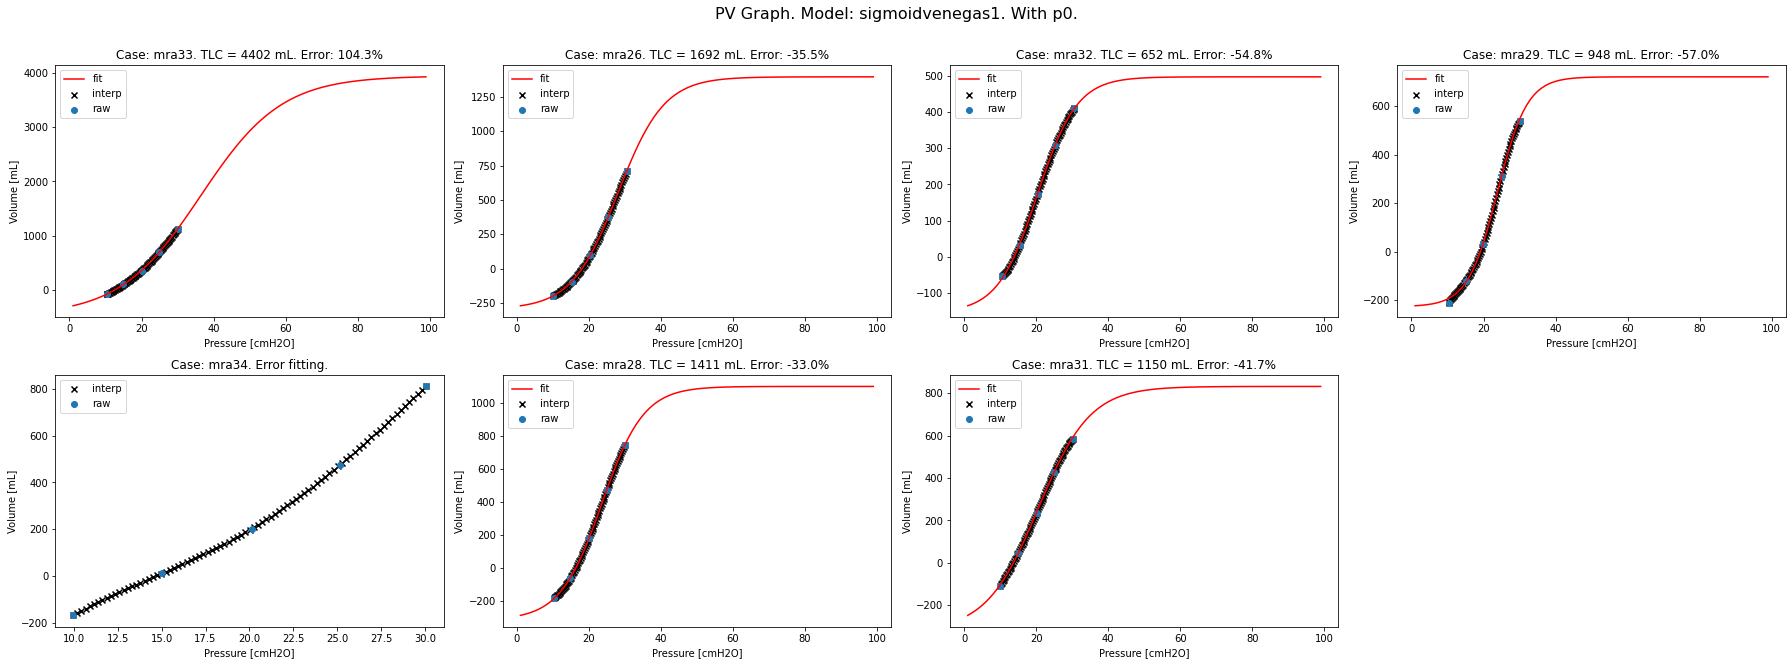

In [19]:
n_points_interp = 20
texto = 'With p0.'
m.testa_modelo(dadosdfD5, modelo, metodo = metodo, meu_p0 = p0, texto = texto, TLC_index=TLC_index, n_points_interp=n_points_interp, debug=debug)

### sigmoidpaiva

In [20]:
# sigmoidpaiva: (TLC,k1,k2): TLC/(1+(k1*np.exp(-k2*x)))
#          offset, Vmax, 'mi', 'sigma'   
bounds = ([  -500,  500,    0,      2],
          [   500, 3500,   40,     40])
p0 =      [  -200, 2000,   25,      5]
TLC_index = 1
metodo = 'trf'
modelo = m.sigmoidpaiva
debug = True

#### Com limites, sem interpolar

#### Com limites, interpolando

#### Sem limites

### sigmoidpaivaoffset2

In [21]:
# sigmoidpaivaoffset2: (TLC,k1,k2,offset): TLC/(1+(k1*TCL*np.exp(-k2*x)))
#            Vmax,      k1,   k2, offset
bounds = ([   500,      0,    0,   -500],
          [  3500,      1,   40,    500])
p0 =      [  2000,   0.01, 0.05,   -200]
TLC_index = 0
metodo = 'trf'
modelo = m.sigmoidpaivaoffset
debug = True

#### Com limites, sem interpolar

Testando caso 0: mra34: [ 3500.0 0.007 0.087  -481.1 ]
Testando caso 1: mra28: [ 1384.2 0.048 0.177  -297.5 ]
Testando caso 2: mra31: [ 1137.7 0.015 0.140  -327.8 ]
Testando caso 3: mra32: [  634.8 0.074 0.187  -139.8 ]
Testando caso 4: mra26: [ 1695.6 0.048 0.156  -294.7 ]
Testando caso 5: mra29: [  968.3 0.241 0.230  -247.6 ]
Testando caso 6: mra33: [ 3499.4 0.008 0.101  -409.1 ]


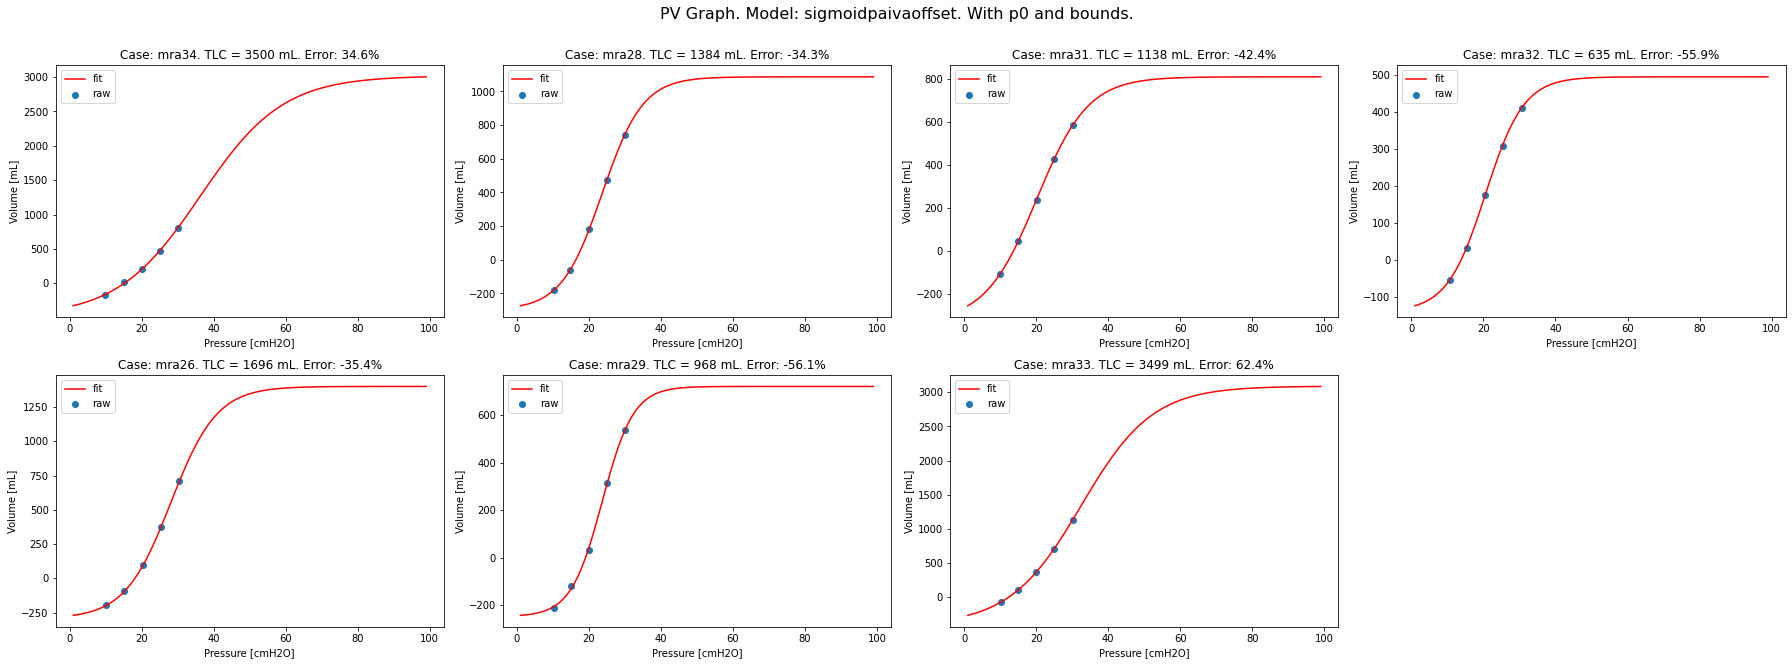

Norma(erro): 124.9. Erro médio: 45.86%. Ajustados: 7.


(124.85240097277213, 45.864340450103384, 7)

Testando caso 0: mra33: [ 3499.4 0.008 0.101  -409.1 ]
Testando caso 1: mra26: [ 1695.6 0.048 0.156  -294.7 ]
Testando caso 2: mra32: [  634.8 0.074 0.187  -139.8 ]
Testando caso 3: mra29: [  968.3 0.241 0.230  -247.6 ]
Testando caso 4: mra34: [ 3500.0 0.007 0.087  -481.1 ]
Testando caso 5: mra28: [ 1384.2 0.048 0.177  -297.5 ]
Testando caso 6: mra31: [ 1137.7 0.015 0.140  -327.8 ]


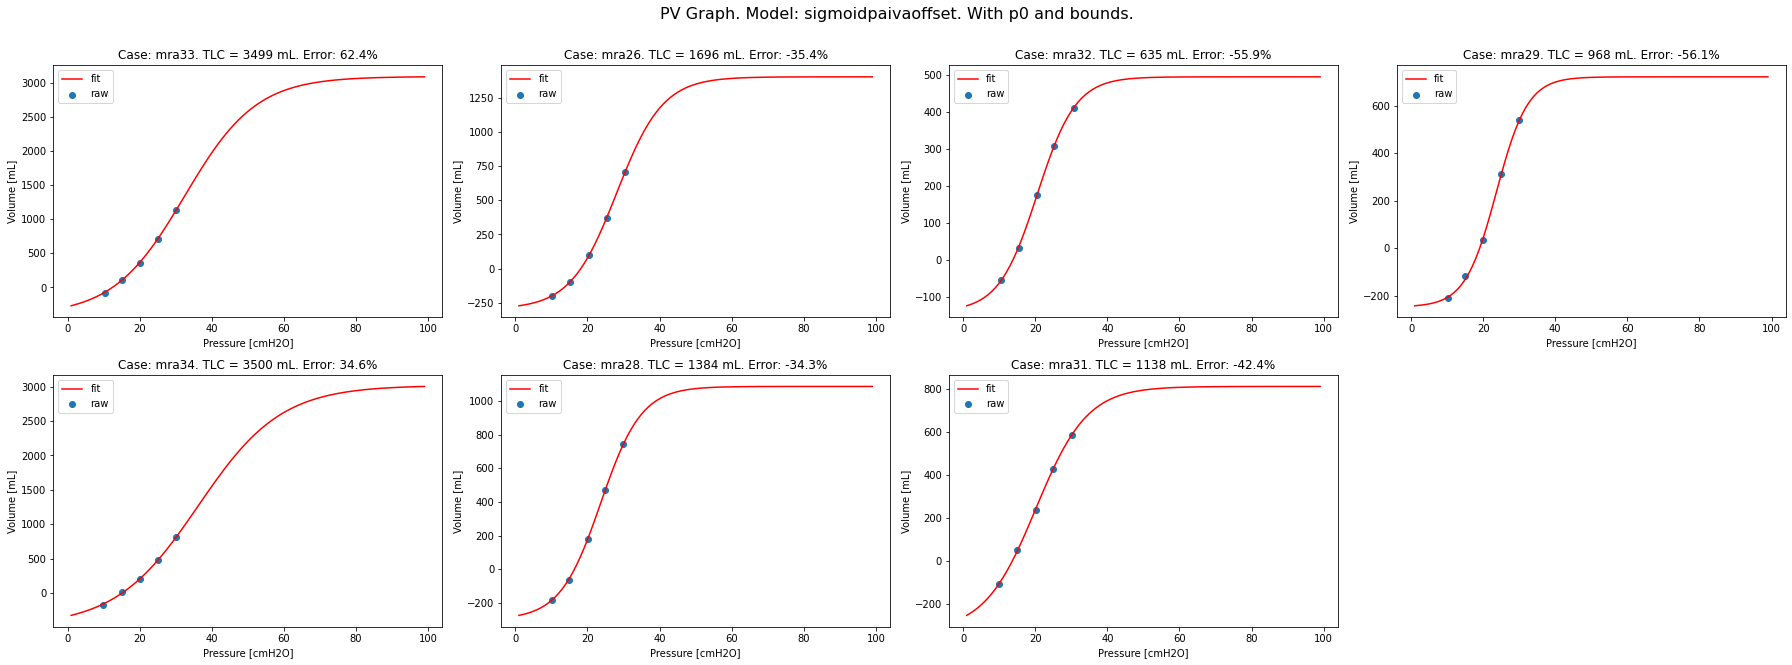

In [22]:
n_points_interp = 0
texto = 'With p0 and bounds.'
m.testa_modelo(dadosdfD5, modelo, metodo = metodo, meu_p0 = p0, texto = texto, TLC_index=TLC_index, meus_bounds=bounds, n_points_interp=n_points_interp, debug=debug)

#### Com limites, interpolando

Testando caso 0: mra34: [ 3500.0 0.008 0.091  -421.3 ]
Testando caso 1: mra28: [ 1411.2 0.042 0.172  -313.4 ]
Testando caso 2: mra31: [ 1150.5 0.015 0.139  -318.6 ]
Testando caso 3: mra32: [  651.6 0.062 0.182  -154.1 ]
Testando caso 4: mra26: [ 1692.1 0.047 0.156  -295.4 ]
Testando caso 5: mra29: [  947.9 0.350 0.243  -226.1 ]
Testando caso 6: mra33: [ 3499.3 0.008 0.101  -398.1 ]


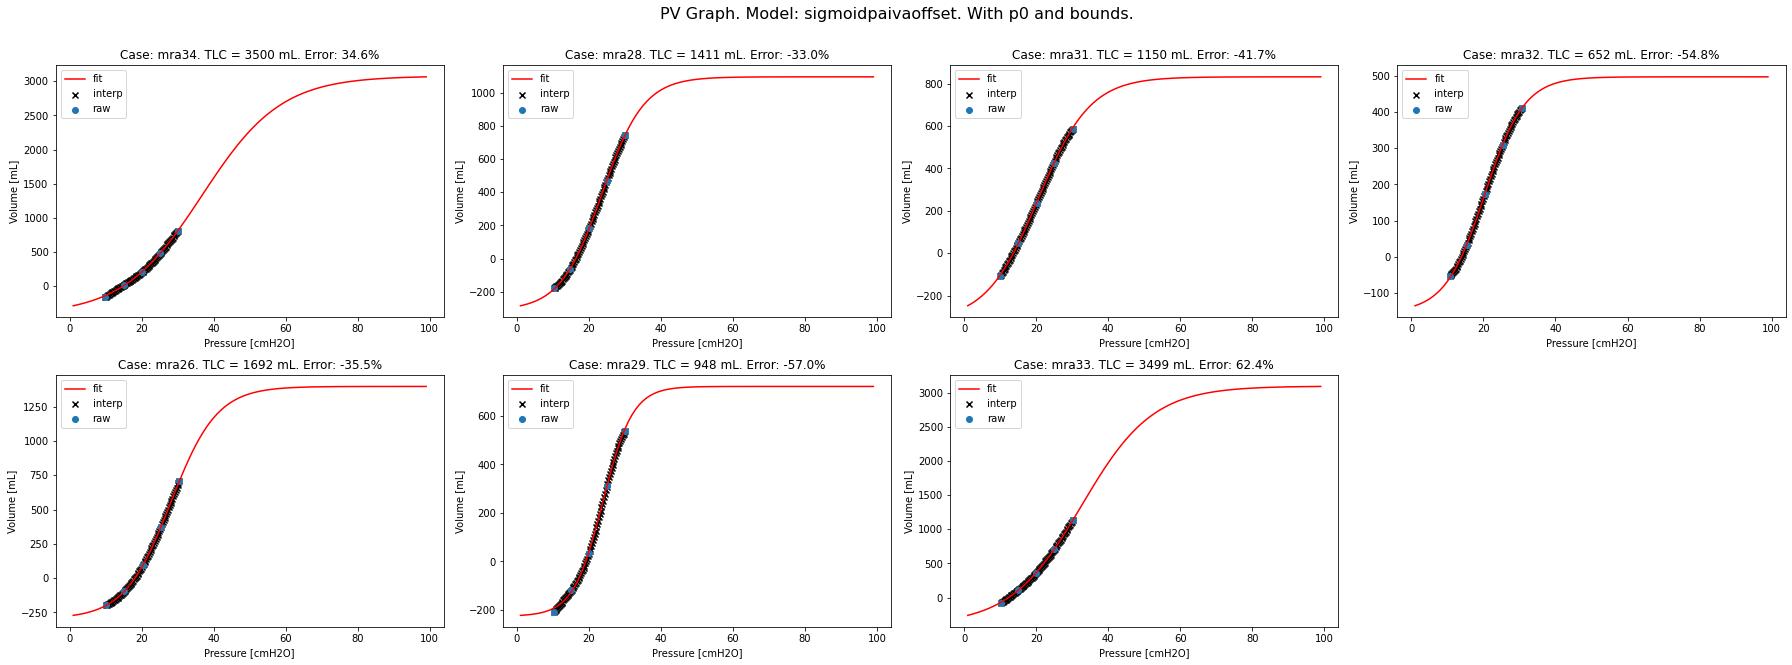

Norma(erro): 124.2. Erro médio: 45.57%. Ajustados: 7.


(124.22673174946824, 45.573217435927134, 7)

Testando caso 0: mra33: [ 3499.3 0.008 0.101  -398.1 ]
Testando caso 1: mra26: [ 1692.1 0.047 0.156  -295.4 ]
Testando caso 2: mra32: [  651.6 0.062 0.182  -154.1 ]
Testando caso 3: mra29: [  947.9 0.350 0.243  -226.1 ]
Testando caso 4: mra34: [ 3500.0 0.008 0.091  -421.3 ]
Testando caso 5: mra28: [ 1411.2 0.042 0.172  -313.4 ]
Testando caso 6: mra31: [ 1150.5 0.015 0.139  -318.6 ]


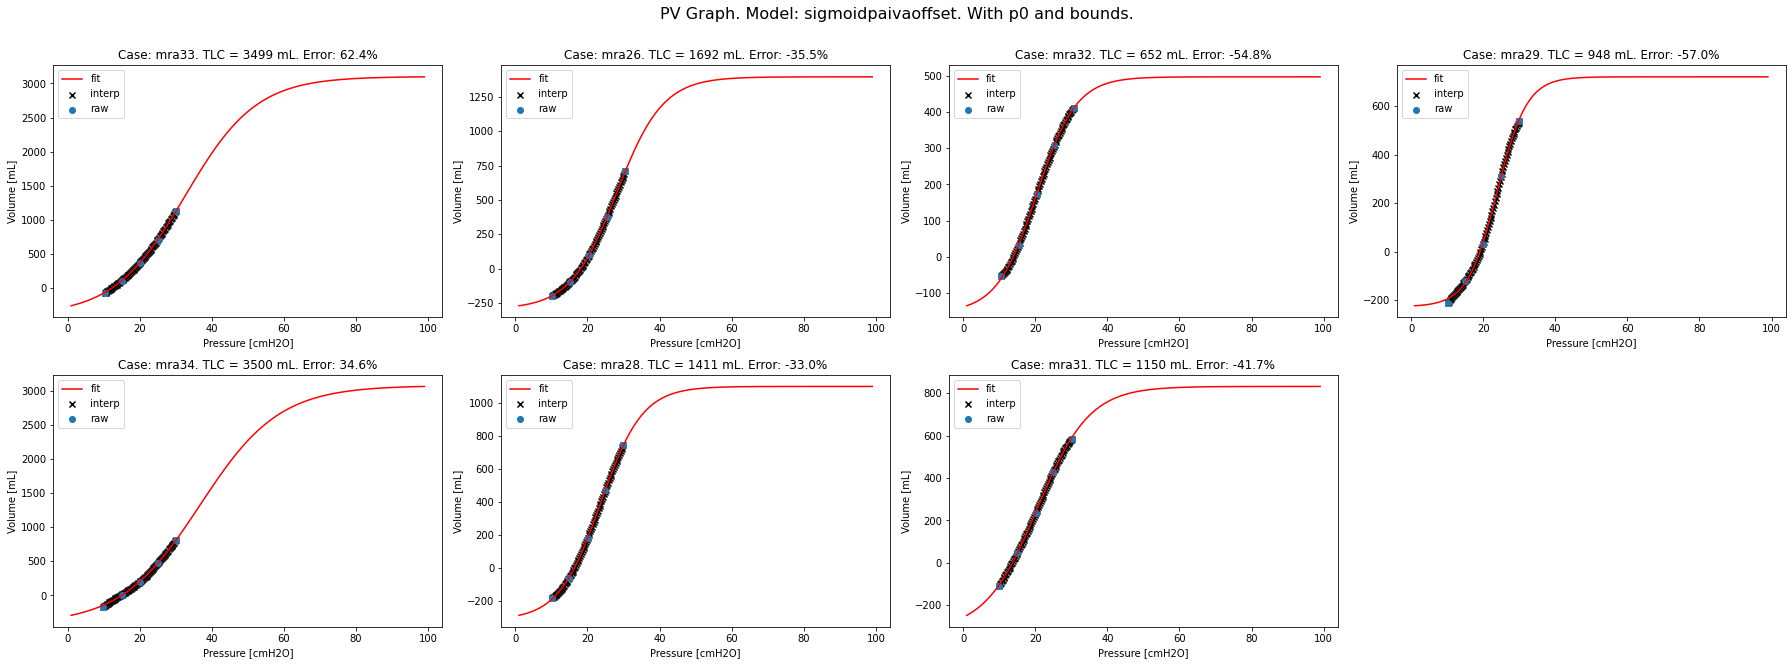

In [23]:
n_points_interp = 20
texto = 'With p0 and bounds.'
m.testa_modelo(dadosdfD5, modelo, metodo = metodo, meu_p0 = p0, texto = texto, TLC_index=TLC_index, meus_bounds=bounds, n_points_interp=n_points_interp, debug=debug)

#### Sem limites

Testando caso 0: mra34: [1334485701.5 0.003 0.054  -652.8 ]
Testando caso 1: mra28: [ 1401.6 0.044 0.174  -308.6 ]
Testando caso 2: mra31: [ 1143.0 0.015 0.140  -319.6 ]
Testando caso 3: mra32: [  644.1 0.067 0.184  -148.6 ]
Testando caso 4: mra26: [ 1700.8 0.047 0.156  -296.0 ]
Testando caso 5: mra29: [  948.5 0.329 0.241  -230.4 ]
Testando caso 6: mra33: [ 4474.5 0.006 0.088  -473.2 ]


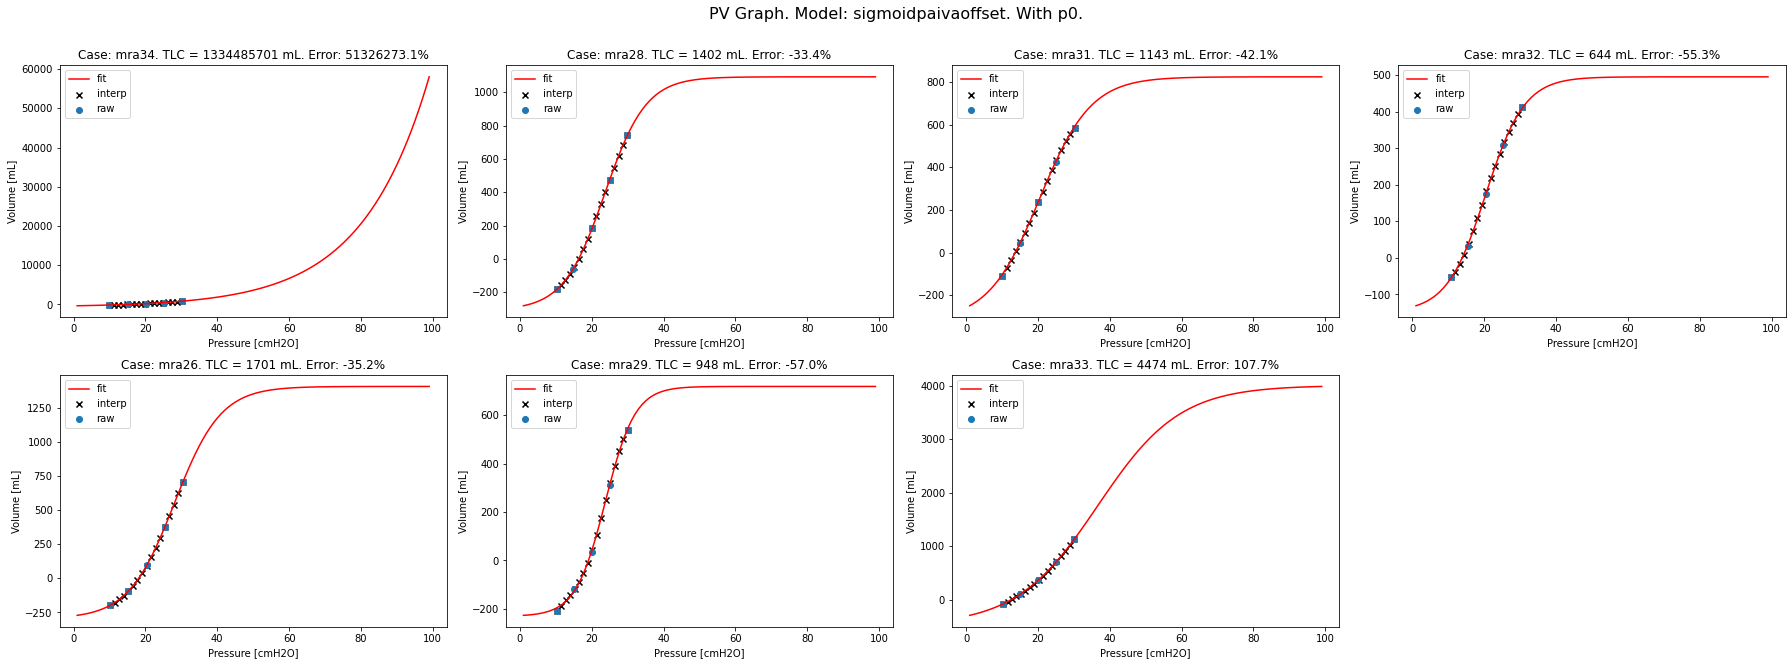

Norma(erro): 51326273.1. Erro médio: 7332371.97%. Ajustados: 7.


(51326273.13331121, 7332371.969675371, 7)

Testando caso 0: mra33: [ 4474.5 0.006 0.088  -473.2 ]
Testando caso 1: mra26: [ 1700.8 0.047 0.156  -296.0 ]
Testando caso 2: mra32: [  644.1 0.067 0.184  -148.6 ]
Testando caso 3: mra29: [  948.5 0.329 0.241  -230.4 ]
Testando caso 4: mra34: [1334485701.5 0.003 0.054  -652.8 ]
Testando caso 5: mra28: [ 1401.6 0.044 0.174  -308.6 ]
Testando caso 6: mra31: [ 1143.0 0.015 0.140  -319.6 ]


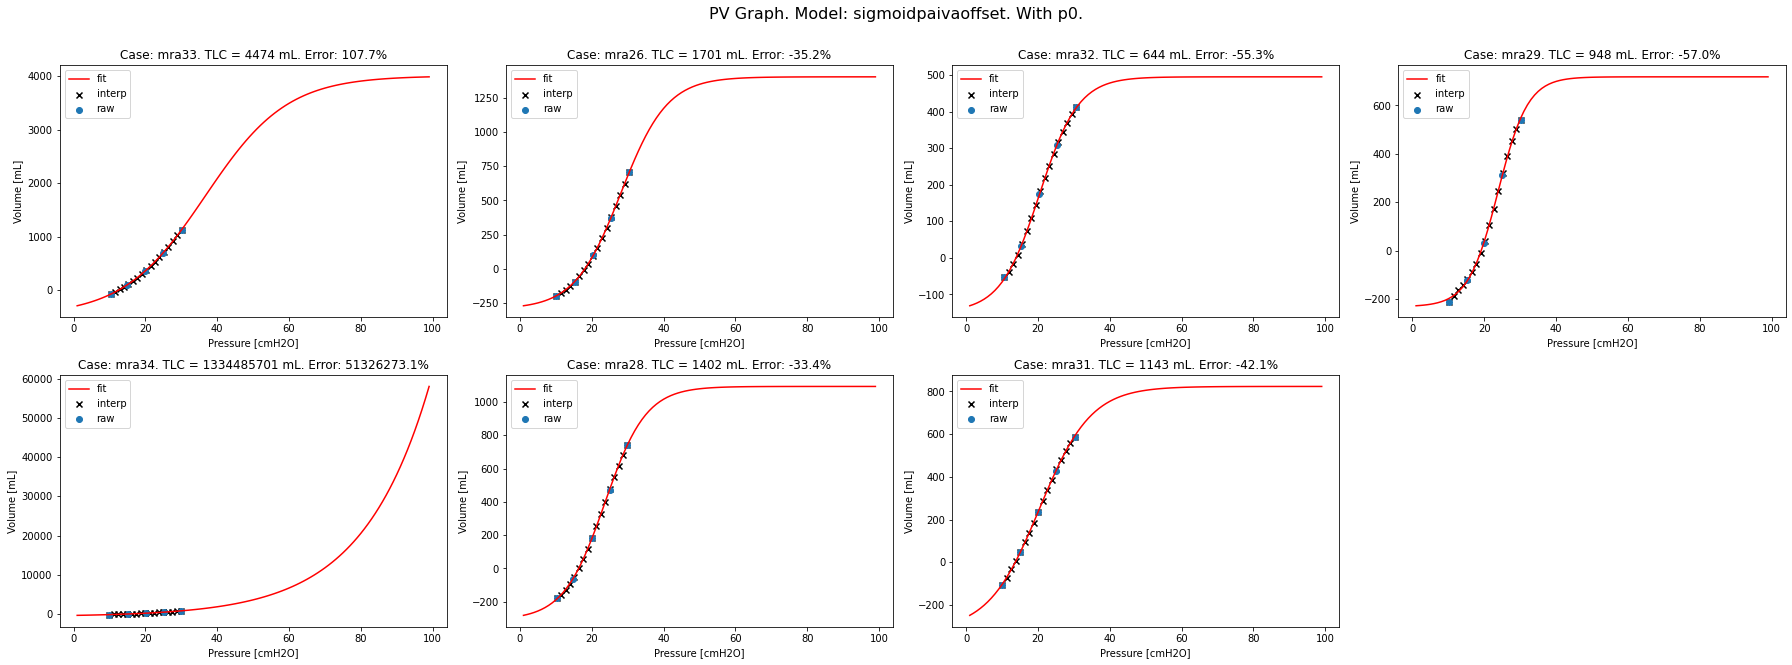

In [24]:
n_points_interp = 3
texto = 'With p0.'
m.testa_modelo(dadosdfD5, modelo, metodo = metodo, meu_p0 = p0, texto = texto,
               TLC_index=TLC_index, n_points_interp=n_points_interp, debug=debug)

### sigmoidvenegas2offset

In [ ]:
# sigmoidvenegas2offset: TLC,B,k,c,d: (TLC-(B*np.exp(-k*x)))/(1 + np.exp(-(x-c)/d)) + offset
#            Vmax,        B,       k,       c,       d,  offset
bounds = ([   500,        0,       0,       0, -np.inf,   -5000 ],
          [  3500,     3500,       1,      40,  np.inf,    5000 ])
p0 =      [  2000,     0.01,    0.05,      10,       1,    -300]
p0 =      [  2000,        1,       1,      32,       7,    -200]
p0 =      [  2000,     2000,    0.05,      28,       7,    -200]
TLC_index = 0
metodo = 'trf'
modelo = m.sigmoidvenegas2offset
debug = True

#### Testa p0

$ V = \dfrac{TLC - Be^{-kP}}{1+e^{-\frac{P-c}{d}}} $

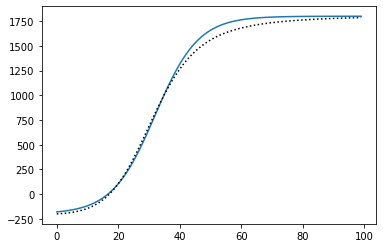

[6. 4.]


In [169]:
#                 TCL,        B,       k,       c,       d,  offset
meu_p0a =      [  2000,       1,       1,      32,       7,    -200]
meu_p0b =      [  2000,    2000,    0.05,      28,       7,    -200]
meu_p = np.asarray(range(0,100))
meu_va = m.sigmoidvenegas2offset(meu_p,*meu_p0a)
meu_vb = m.sigmoidvenegas2offset(meu_p,*meu_p0b)
plt.figure(figsize=(6,4)) # tamanho padrão (6,4)
plt.plot(meu_p,meu_va)
plt.plot(meu_p,meu_vb,'k:')
fig = plt.gcf()
plt.show()
size = fig.get_size_inches()#*fig.dpi # size in pixels
print(size)

#### Testa equação original (incorreta), com sinal trocado, pois quando $P \to c$, $V \to \infty$

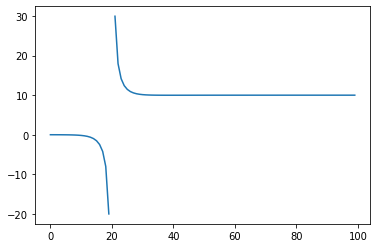

[6. 4.]


In [102]:
meu_p0 =      [  10,     1,    0.1,      20,      2.5]
meu_p = np.asarray(range(0,100))
meu_v = m.sigmoidvenegas2original(meu_p,*meu_p0)
plt.figure(figsize=(6,4)) # tamanho padrão (6,4)
plt.plot(meu_p,meu_v)
fig = plt.gcf()
plt.show()
size = fig.get_size_inches()#*fig.dpi # size in pixels
print(size)

#### Com limites, sem interpolar

Testando caso 0: mra34: [ 3500.0 -24309.1   244.6    36.3    11.5  -481.1 ]
Testando caso 1: mra28: [ 1384.2   797.2   755.2    23.7     5.6  -297.5 ]
Testando caso 2: mra31: [ 1137.7  5607.4  1934.3    20.1     7.1  -327.8 ]
	Caso 3 (mra32) deu erro...
Testando caso 4: mra26: [ 1695.6   -25.0    17.5    28.1     6.4  -294.7 ]
Testando caso 5: mra29: [  968.3   168.4    92.2    23.7     4.3  -247.6 ]
Testando caso 6: mra33: [ 3500.0  -420.4     2.4    32.5     9.9  -413.4 ]


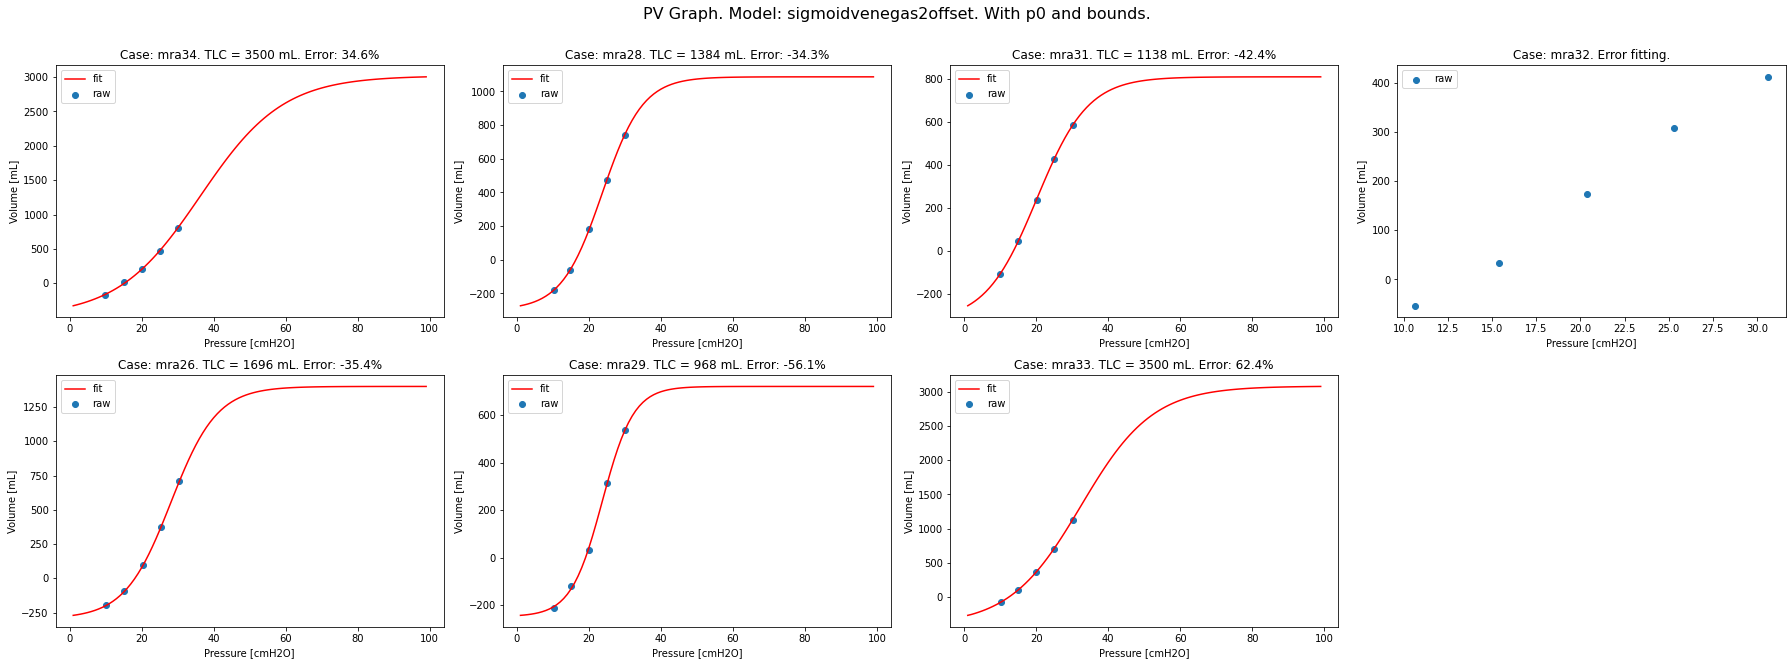

Norma(erro): 85.3. Erro médio: 35.90%. Ajustados: 5.


(85.31152926697898, 35.8991619165149, 5)

In [ ]:
n_points_interp = 0
texto = 'With p0 and bounds.'
m.testa_modelo(dadosdfD5, modelo, metodo = metodo, meu_p0 = p0, texto = texto, TLC_index=TLC_index, meus_bounds=bounds, n_points_interp=n_points_interp, debug=debug)

#### Com limites, interpolando

Testando caso 0: mra34: [ 3500.0  1596.0    28.0    36.6    11.2  -443.6 ]
Testando caso 1: mra28: [ 1398.3    39.2     3.8    23.6     5.7  -306.8 ]
Testando caso 2: mra31: [ 1140.7   245.2     6.2    20.4     7.1  -320.1 ]
Testando caso 3: mra32: [  641.6    14.0     2.3    20.4     5.4  -146.7 ]
Testando caso 4: mra26: [ 1703.3     2.7     8.8    28.2     6.4  -296.1 ]
Testando caso 5: mra29: [  949.1  -164.7     4.5    23.8     4.2  -232.2 ]
Testando caso 6: mra33: [ 3500.0   877.0    20.0    32.6     9.9  -404.6 ]


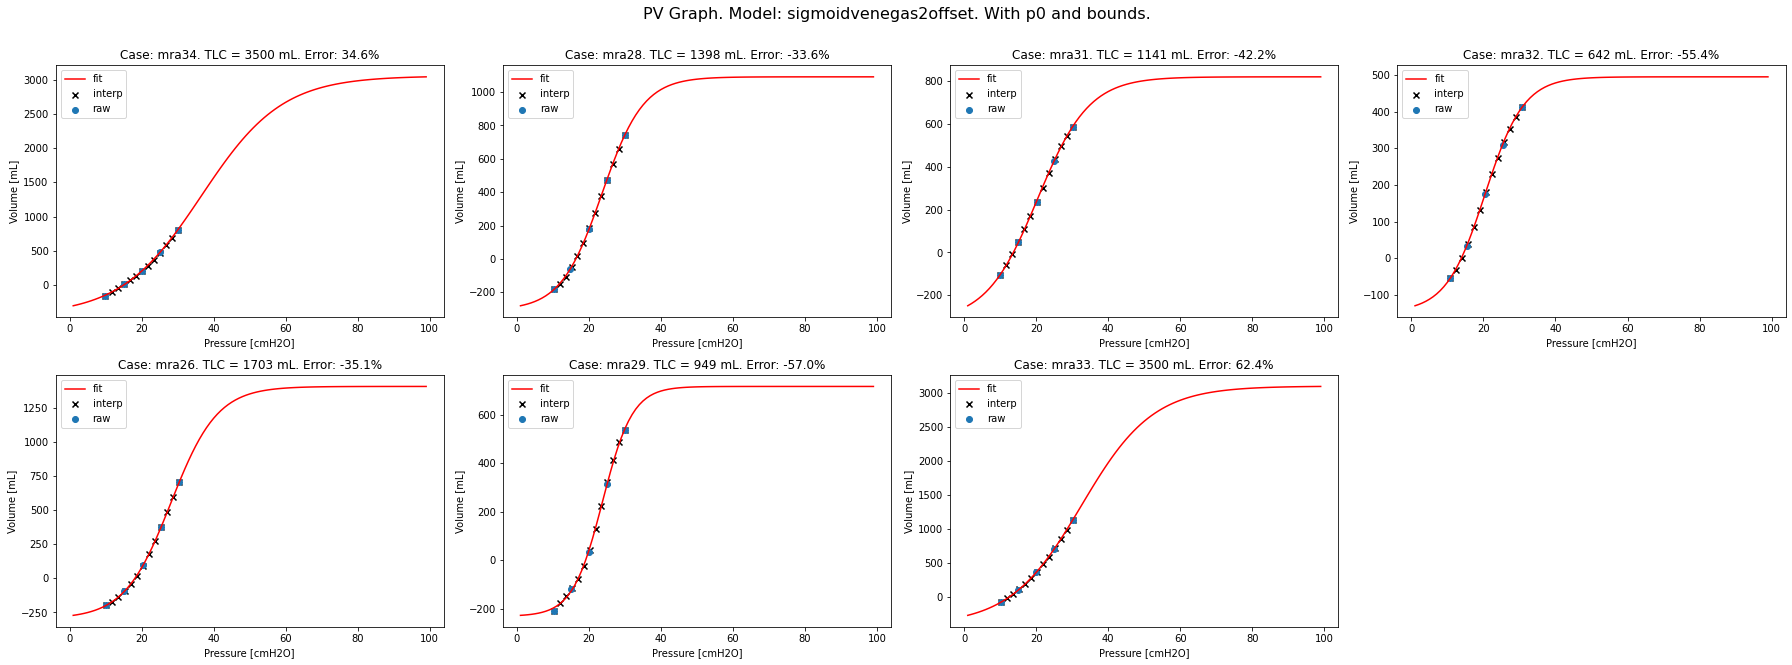

Norma(erro): 124.7. Erro médio: 45.77%. Ajustados: 7.


(124.73459900629953, 45.766288802628615, 7)

Testando caso 0: mra33: [ 3500.0   877.0    20.0    32.6     9.9  -404.6 ]
Testando caso 1: mra26: [ 1703.3     2.7     8.8    28.2     6.4  -296.1 ]
Testando caso 2: mra32: [  641.6    14.0     2.3    20.4     5.4  -146.7 ]
Testando caso 3: mra29: [  949.1  -164.7     4.5    23.8     4.2  -232.2 ]
Testando caso 4: mra34: [ 3500.0  1596.0    28.0    36.6    11.2  -443.6 ]
Testando caso 5: mra28: [ 1398.3    39.2     3.8    23.6     5.7  -306.8 ]
Testando caso 6: mra31: [ 1140.7   245.2     6.2    20.4     7.1  -320.1 ]


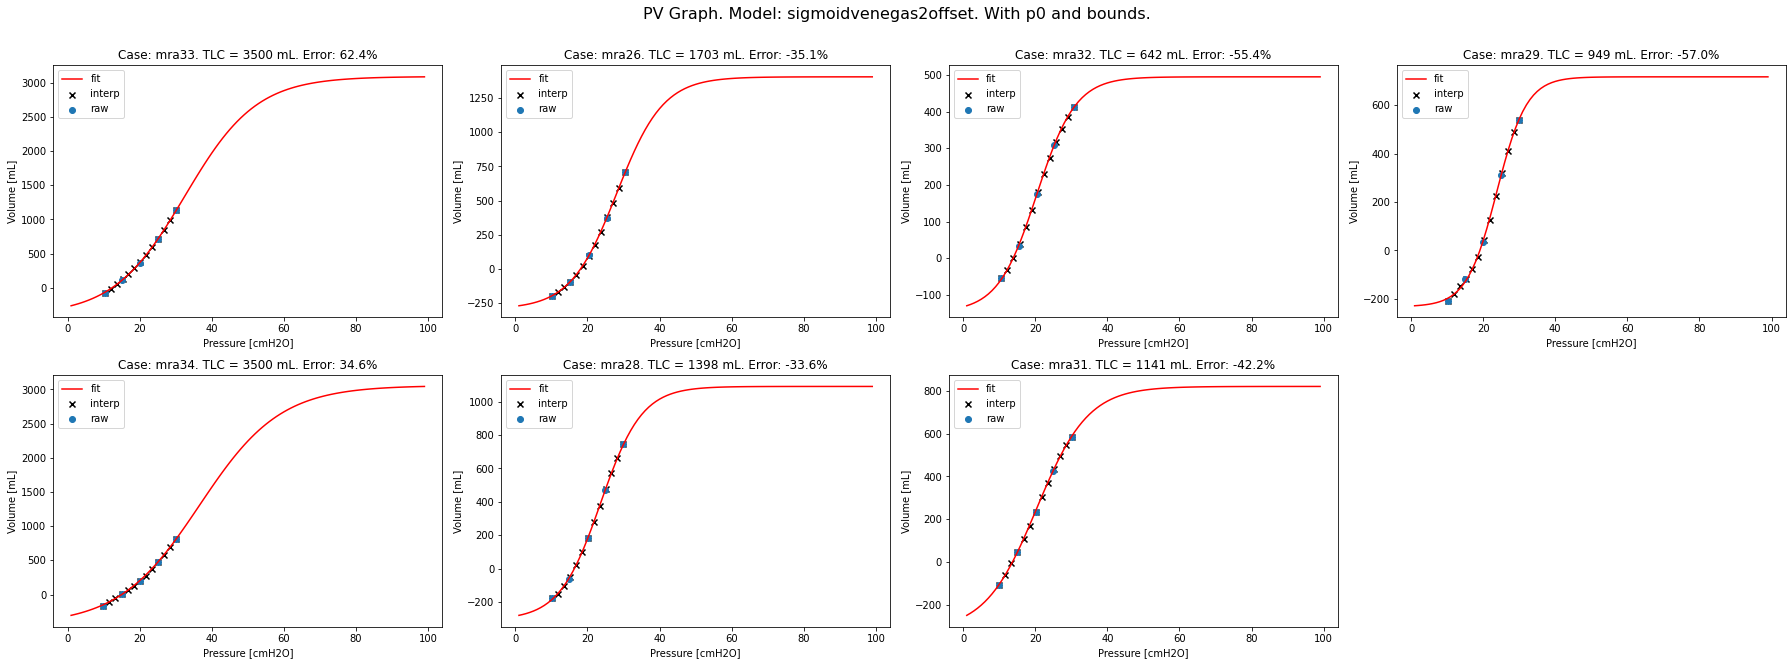

In [27]:
n_points_interp = 2
texto = 'With p0 and bounds.'
m.testa_modelo(dadosdfD5, modelo, metodo = metodo, meu_p0 = p0, texto = texto, TLC_index=TLC_index,
               meus_bounds=bounds, n_points_interp=n_points_interp, debug=debug)

#### Sem limites

	Caso 0 (mra34) deu erro...
	Caso 1 (mra28) deu erro...
	Caso 2 (mra31) deu erro...
	Caso 3 (mra32) deu erro...
	Caso 4 (mra26) deu erro...
	Caso 5 (mra29) deu erro...
Testando caso 6: mra33: [ 4474.5 -6685.8  2624.1    36.7    11.4  -473.2 ]


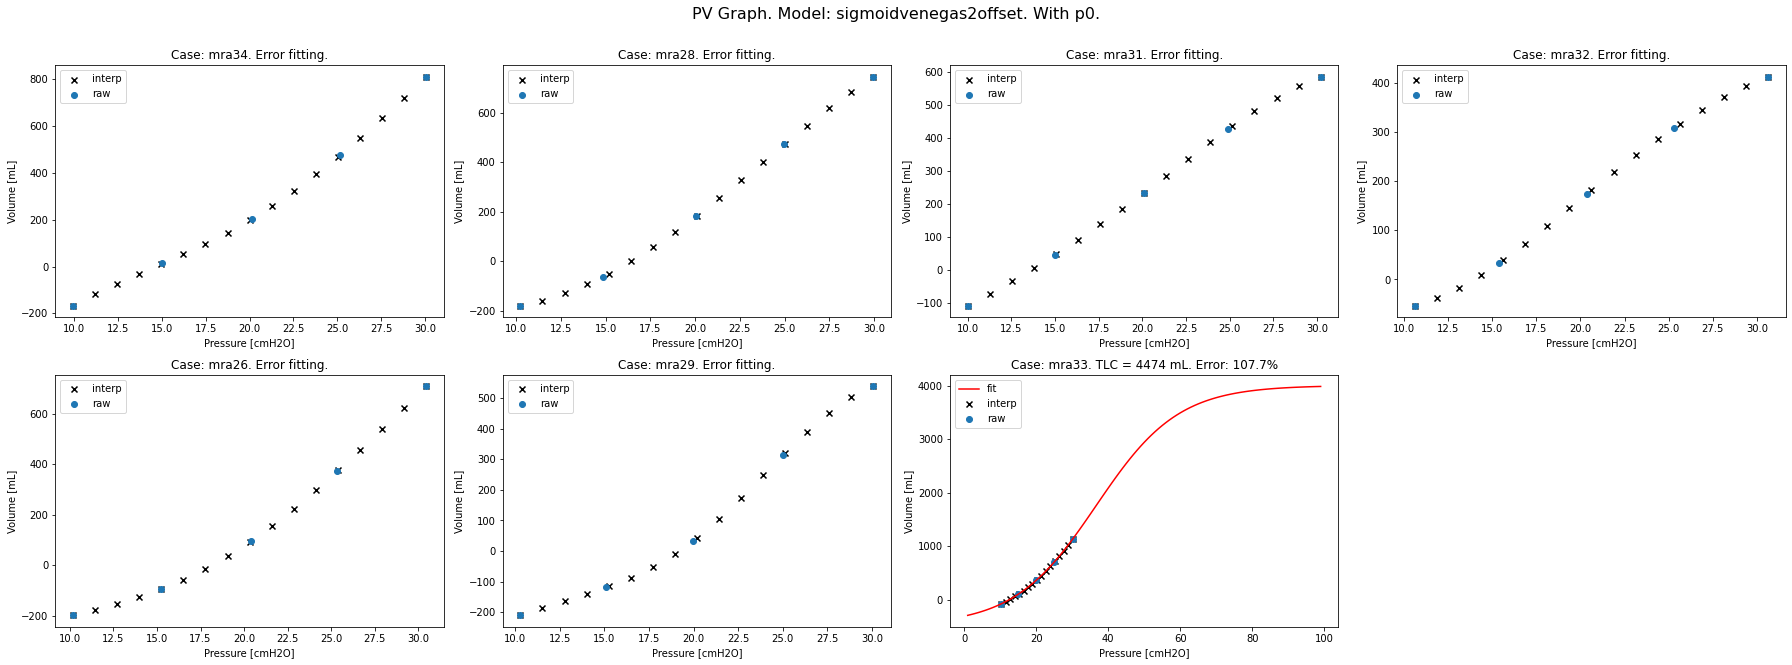

Norma(erro): 107.7. Erro médio: 107.67%. Ajustados: 1.


(107.67074523178186, 107.67074523178186, 1)

Testando caso 0: mra33: [ 4474.5 -6685.8  2624.1    36.7    11.4  -473.2 ]
	Caso 1 (mra26) deu erro...
	Caso 2 (mra32) deu erro...
	Caso 3 (mra29) deu erro...
	Caso 4 (mra34) deu erro...
	Caso 5 (mra28) deu erro...
	Caso 6 (mra31) deu erro...


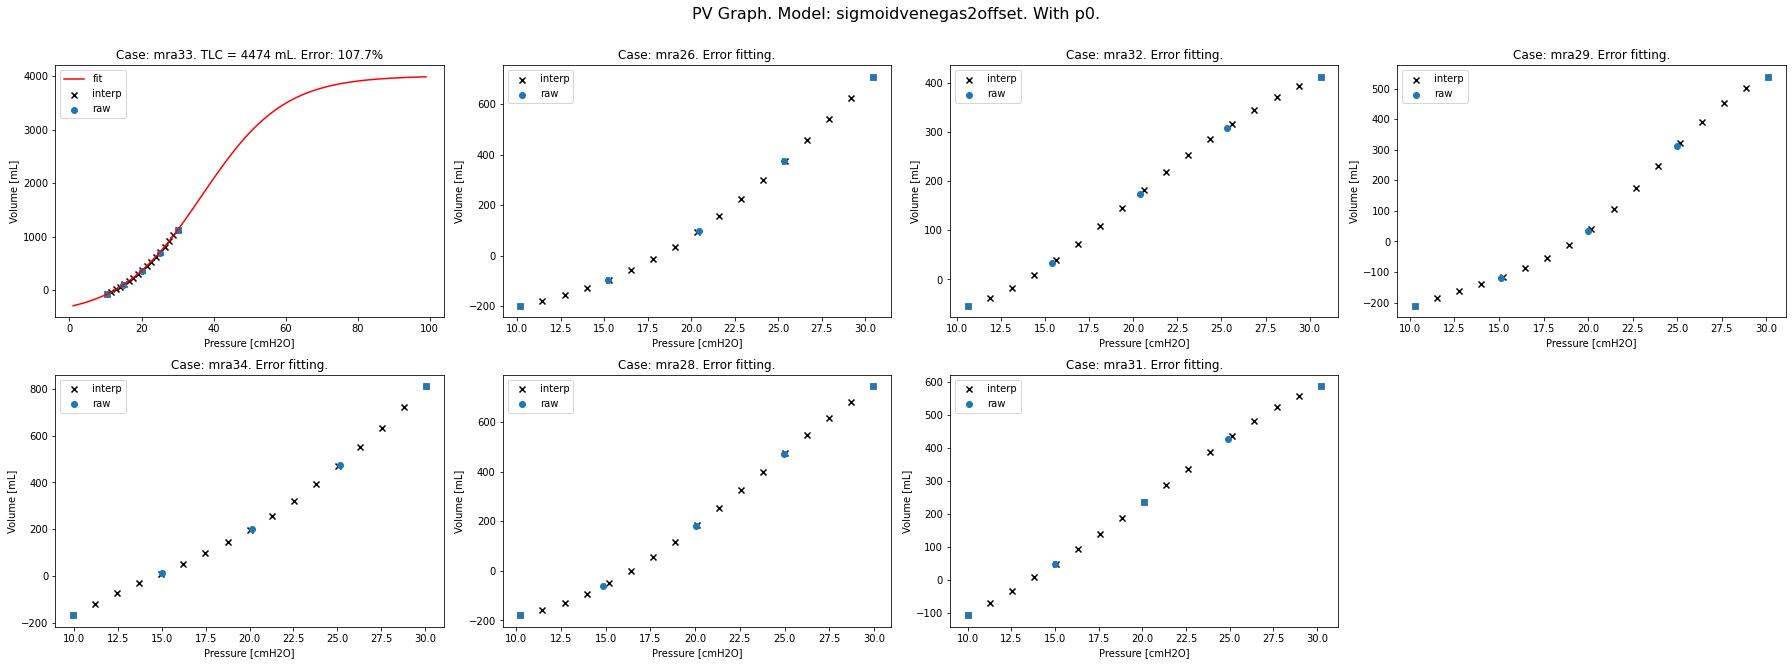

In [28]:
n_points_interp = 3
texto = 'With p0.'
m.testa_modelo(dadosdfD5, modelo, metodo = metodo, meu_p0 = p0, texto = texto,
               TLC_index=TLC_index, n_points_interp=n_points_interp, debug=debug)

### Murphy e Engel

In [29]:
# sigmoidmurphy: VM,Vm,k1,k2,k3:
#               VM,      Vm,      k1,      k2,      k3
bounds = ([    500,    -500,     100,     100,    -100],
          [   3500,       0,  100000,  100000,     100])
p0 =      [ 2000.0,  -200.0,  1000.0,  1000.0,    20.0]
TLC_index = 0
metodo = 'trf'
modelo = m.sigmoidmurphy
debug = True
invert_PV = True

#### Com limites, sem interpolar

Testando caso 0: mra34: [ 3363.8  -500.0 100000.0  4351.8    -5.6 ]
Testando caso 1: mra28: [ 2872.4  -391.4 82597.4  2079.0    -7.0 ]
Testando caso 2: mra31: [ 1350.8  -500.0 19650.3  4908.9     9.0 ]
Testando caso 3: mra32: [  790.4  -214.4  8477.6  1655.0    10.9 ]
Testando caso 4: mra26: [ 3500.0  -452.6 100000.0  3761.3    -2.1 ]
	Caso 5 (mra29) deu erro...
Testando caso 6: mra33: [ 3500.0  -500.0 67655.6  6027.9     5.4 ]


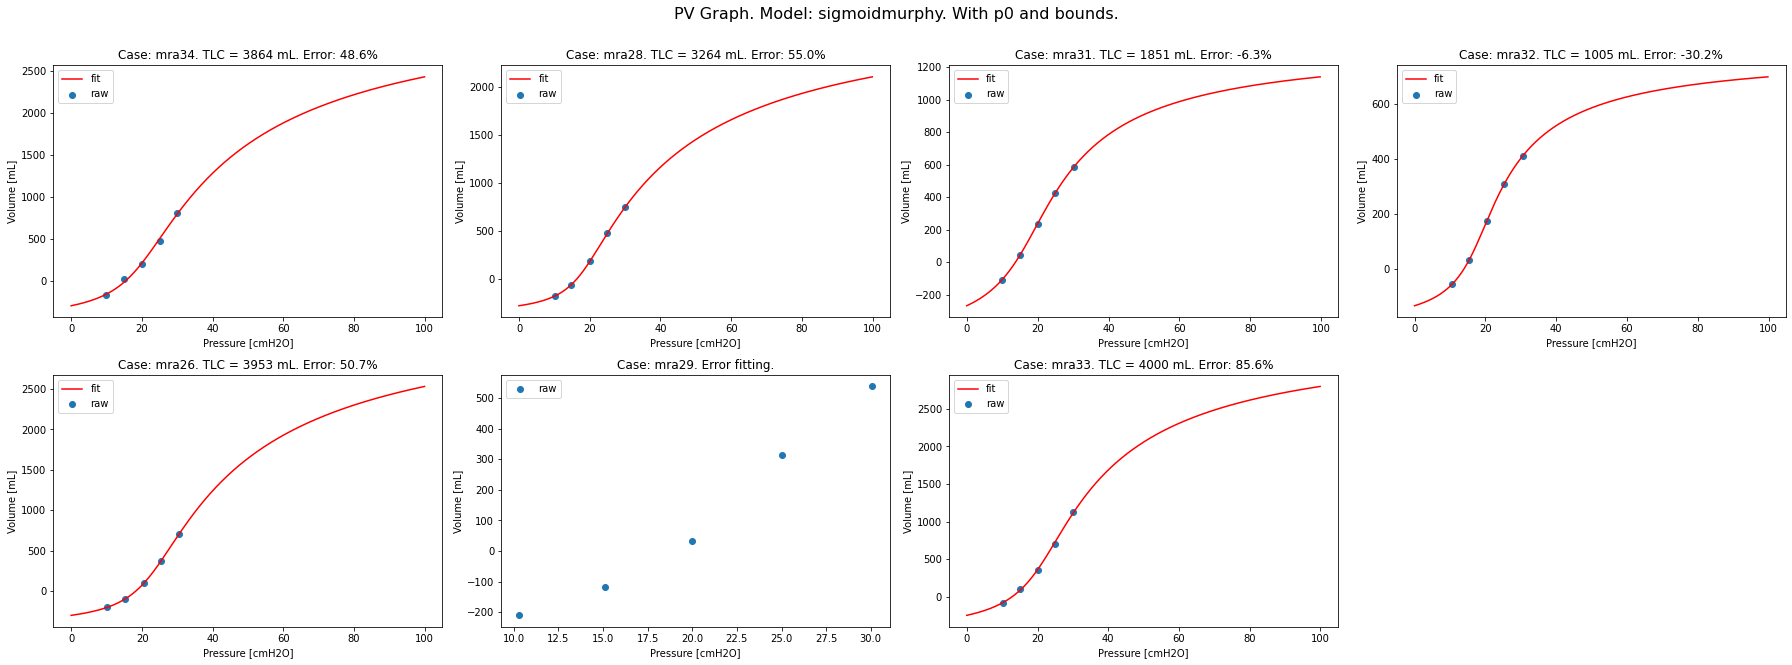

Norma(erro): 127.5. Erro médio: 46.07%. Ajustados: 6.


(127.45583319770996, 46.0718550990039, 6)

Testando caso 0: mra33: [ 3500.0  -500.0 67655.6  6027.9     5.4 ]
Testando caso 1: mra26: [ 3500.0  -452.6 100000.0  3761.3    -2.1 ]
Testando caso 2: mra32: [  790.4  -214.4  8477.6  1655.0    10.9 ]
	Caso 3 (mra29) deu erro...
Testando caso 4: mra34: [ 3363.8  -500.0 100000.0  4351.8    -5.6 ]
Testando caso 5: mra28: [ 2872.4  -391.4 82597.4  2079.0    -7.0 ]
Testando caso 6: mra31: [ 1350.8  -500.0 19650.3  4908.9     9.0 ]


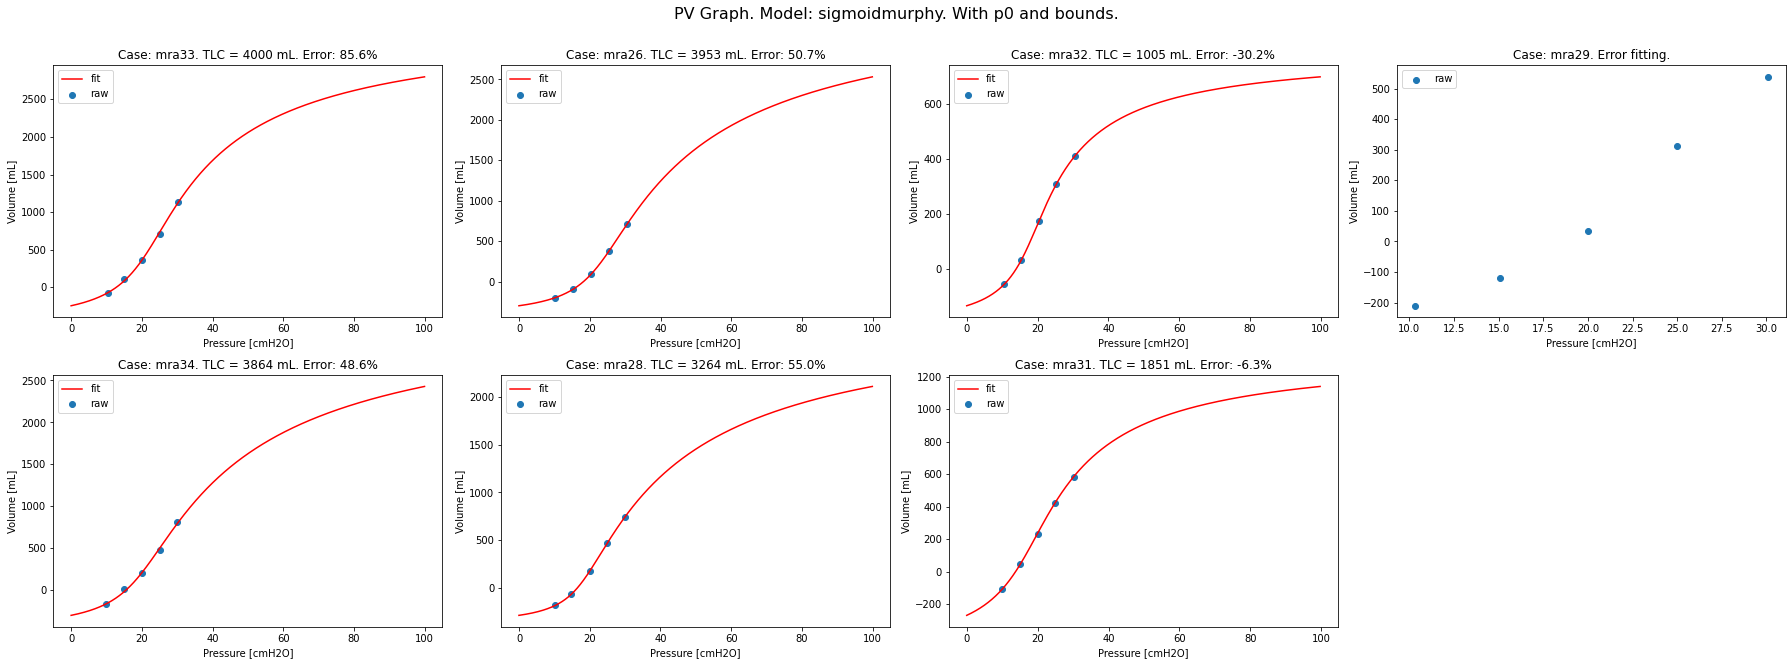

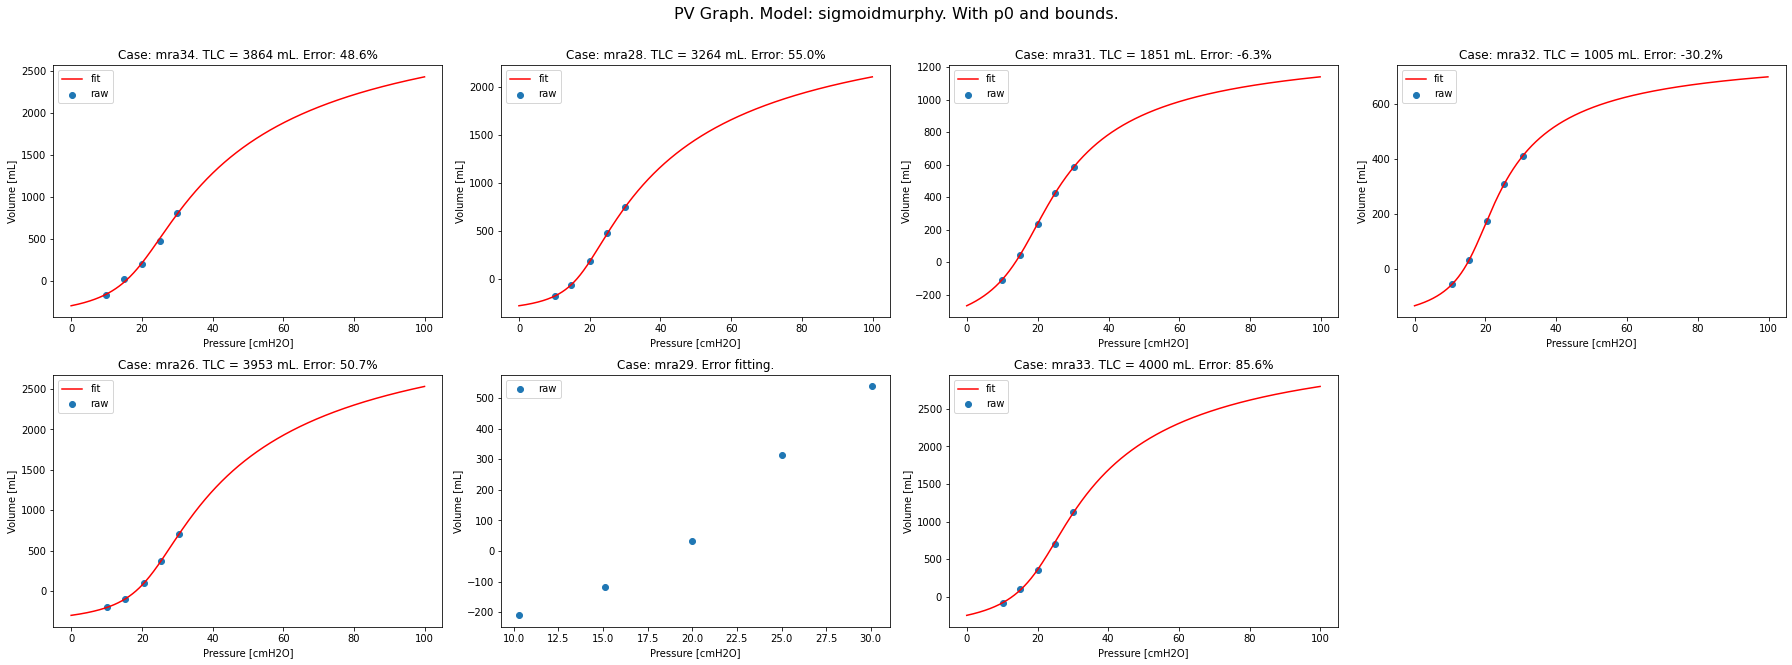

In [30]:
n_points_interp = 0
texto = 'With p0 and bounds.'
m.testa_modelo(dadosdfD5, modelo, metodo = metodo, meu_p0 = p0, texto = texto, TLC_index=TLC_index,
               meus_bounds=bounds, n_points_interp=n_points_interp, debug=debug, invert_PV = invert_PV)

#### Com limites, interpolando

Testando caso 0: mra34: [ 3409.6  -500.0 100000.0  5071.3    -4.0 ]
Testando caso 1: mra28: [ 3104.4  -392.7 100000.0  1990.3   -10.7 ]
Testando caso 2: mra31: [ 1443.3  -500.0 22719.4  5082.8     8.1 ]
Testando caso 3: mra32: [  882.0  -188.0 12466.8  1129.4     5.8 ]
Testando caso 4: mra26: [ 3486.9  -456.1 100000.0  3790.4    -2.2 ]
	Caso 5 (mra29) deu erro...
Testando caso 6: mra33: [ 3500.0  -500.0 68738.8  6341.6     5.4 ]


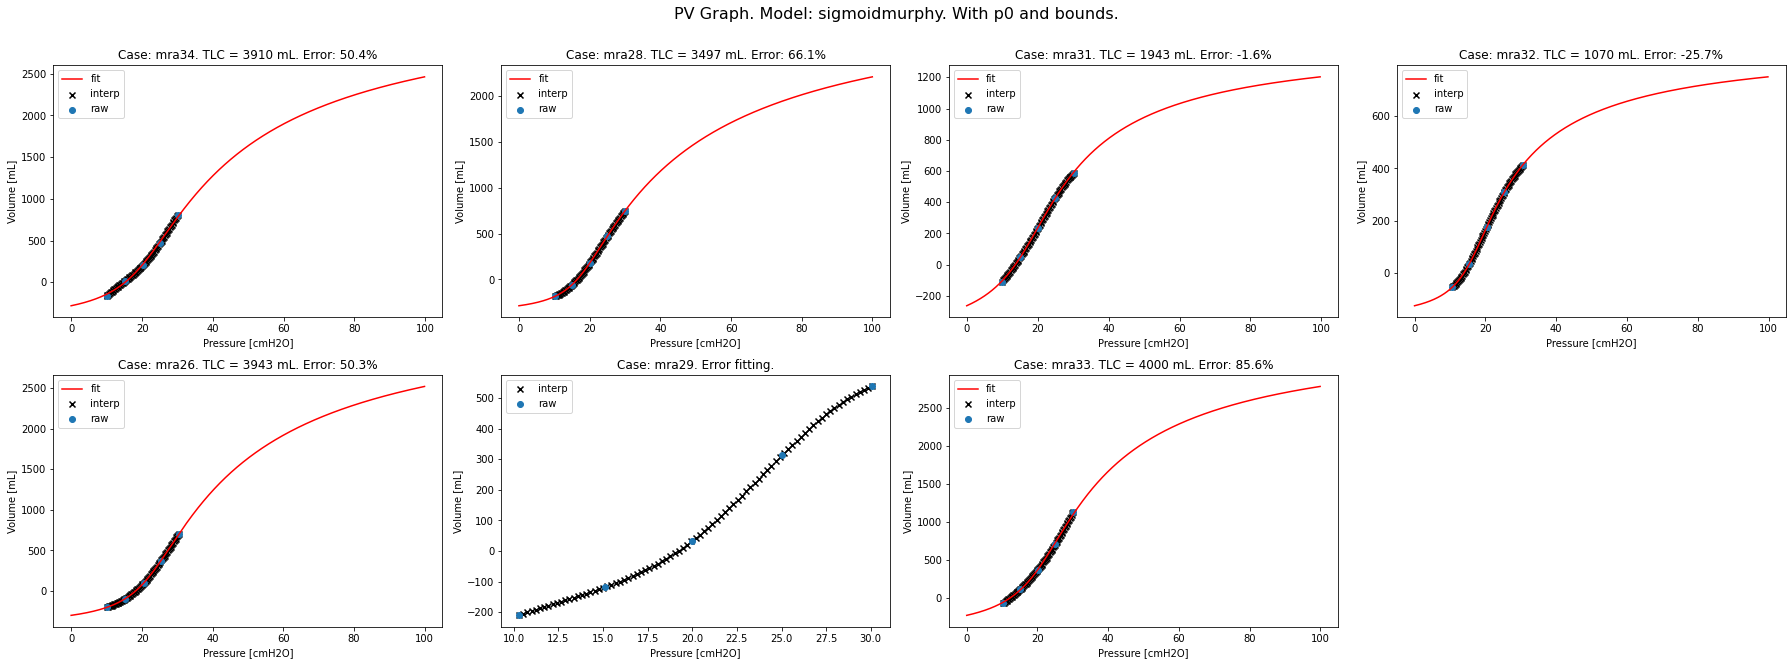

Norma(erro): 134.4. Erro médio: 43.52%. Ajustados: 7.
Testando caso 0: mra33: [ 3500.0  -500.0 68738.8  6341.6     5.4 ]
Testando caso 1: mra26: [ 3486.9  -456.1 100000.0  3790.4    -2.2 ]
Testando caso 2: mra32: [  882.0  -188.0 12466.9  1129.4     5.8 ]
Testando caso 3: mra29: [ 1456.5  -198.3 31380.7   100.0    -3.0 ]
Testando caso 4: mra34: [ 3409.6  -500.0 100000.0  5071.3    -4.0 ]
Testando caso 5: mra28: [ 3104.4  -392.7 100000.0  1990.3   -10.7 ]
Testando caso 6: mra31: [ 1443.3  -500.0 22719.4  5082.8     8.1 ]


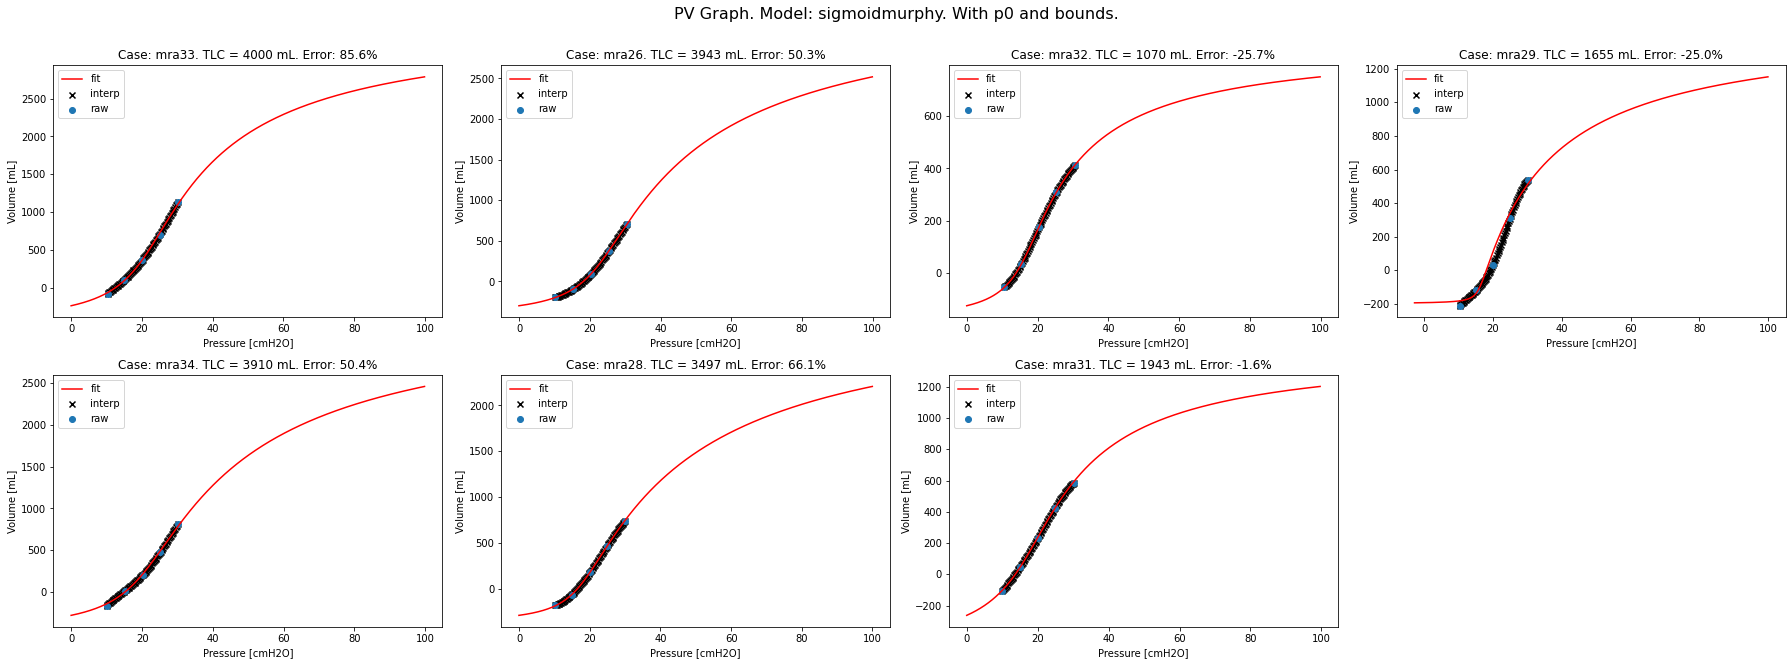

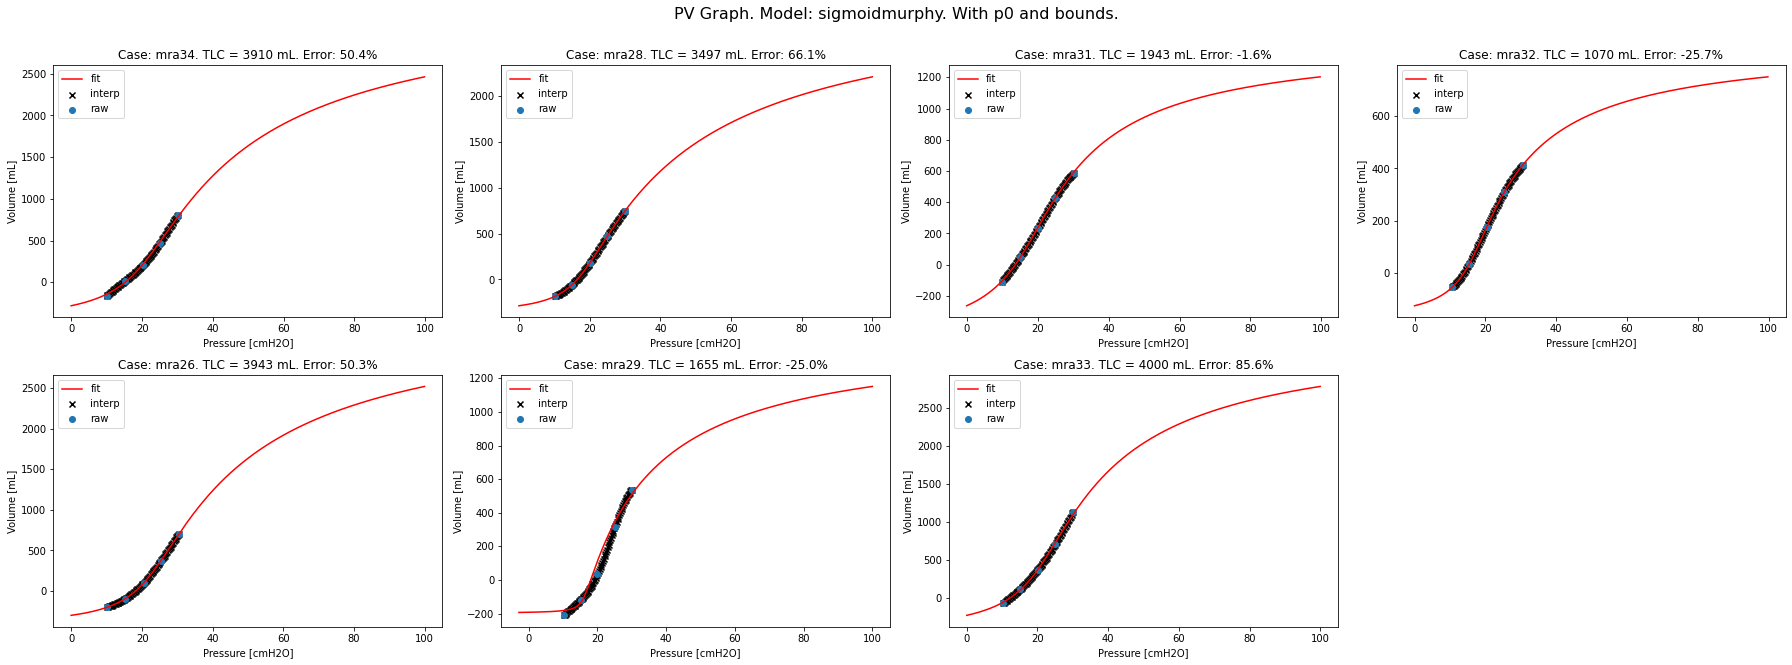

(132.034849879136, 46.61518967237877, 6)

In [31]:
n_points_interp = 20
texto = 'With p0 and bounds.'
m.testa_modelo(dadosdfD5, modelo, metodo = metodo, meu_p0 = p0, texto = texto, TLC_index=TLC_index,
               meus_bounds=bounds, n_points_interp=n_points_interp, debug=debug, invert_PV = invert_PV)

#### Sem limites

	Caso 0 (mra34) deu erro...
Testando caso 1: mra28: [ 2872.4  -391.4 82597.4  2079.0    -7.0 ]
Testando caso 2: mra31: [  741.9 -1520.0   816.8 68308.6    57.4 ]
Testando caso 3: mra32: [  790.4  -214.4  8477.6  1655.0    10.9 ]
Testando caso 4: mra26: [ 5836.7  -424.3 337175.3  2950.7   -32.7 ]
	Caso 5 (mra29) deu erro...
Testando caso 6: mra33: [ 1396.1 -1484.5   381.9 56810.5    50.4 ]


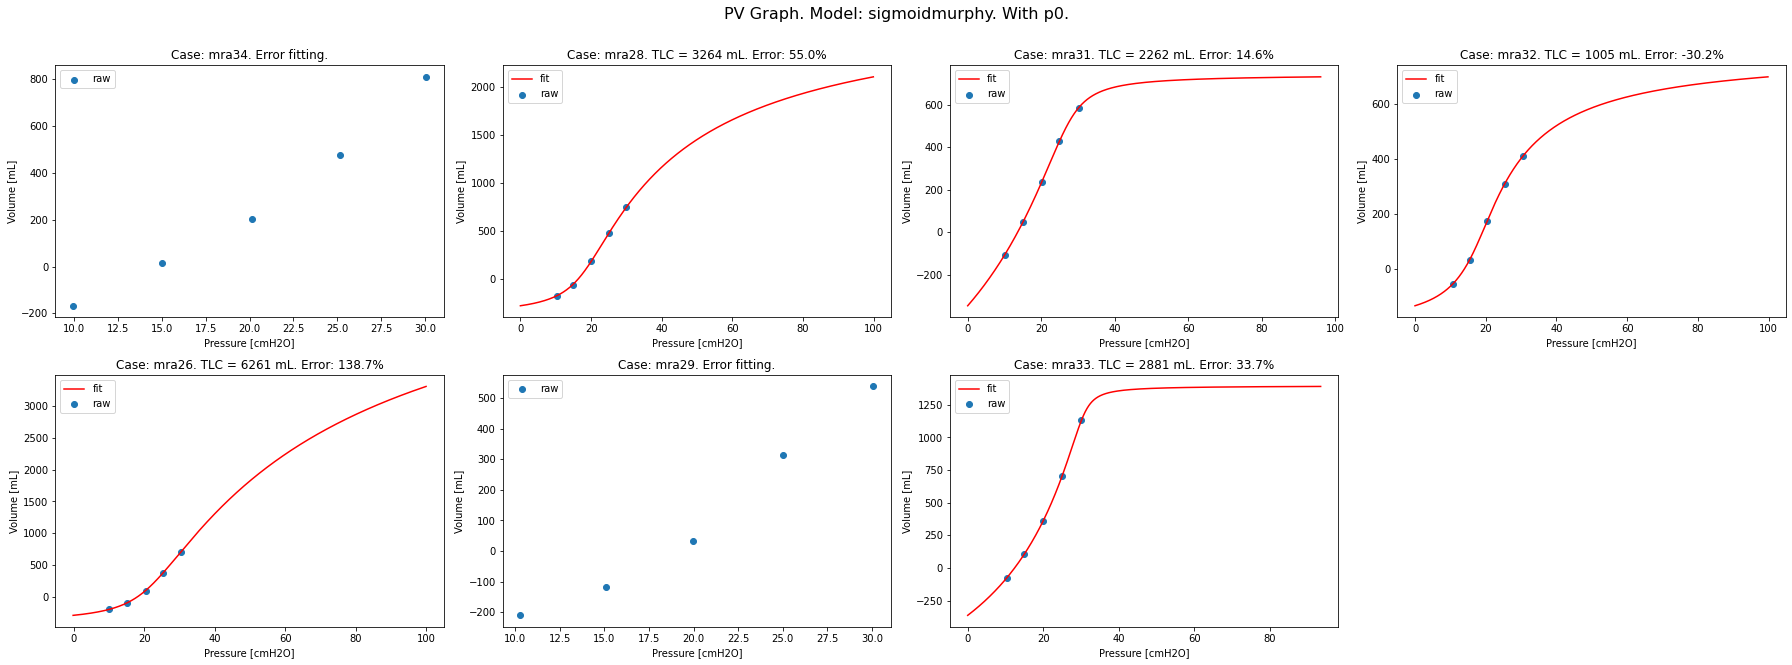

Norma(erro): 47.6. Erro médio: 26.16%. Ajustados: 3.
Testando caso 0: mra33: [ 1396.1 -1484.5   381.9 56810.5    50.4 ]
	Caso 1 (mra26) deu erro...
Testando caso 2: mra32: [  790.4  -214.4  8477.6  1655.0    10.9 ]
	Caso 3 (mra29) deu erro...
	Caso 4 (mra34) deu erro...
	Caso 5 (mra28) deu erro...
Testando caso 6: mra31: [  741.9 -1520.0   816.8 68308.6    57.4 ]


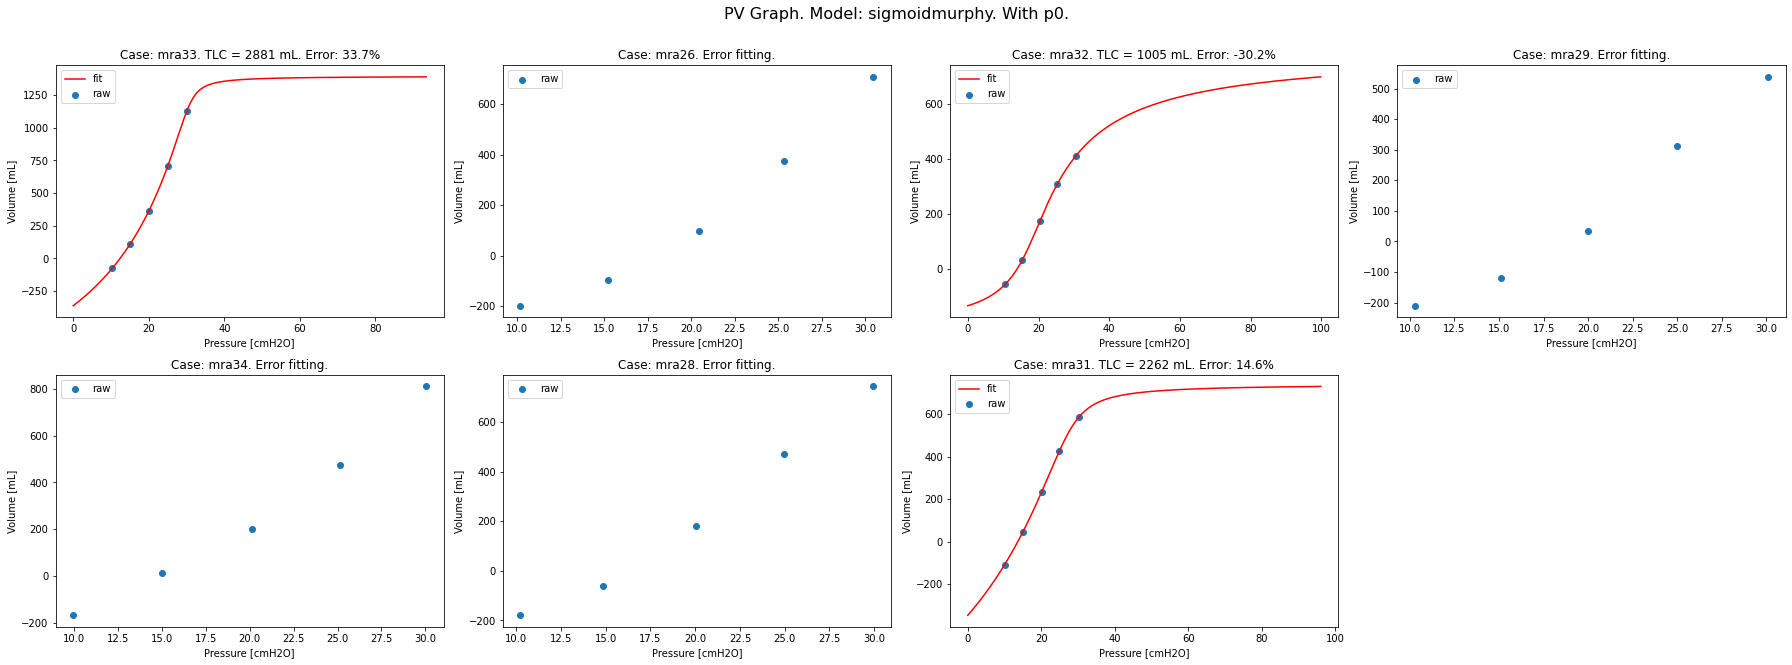

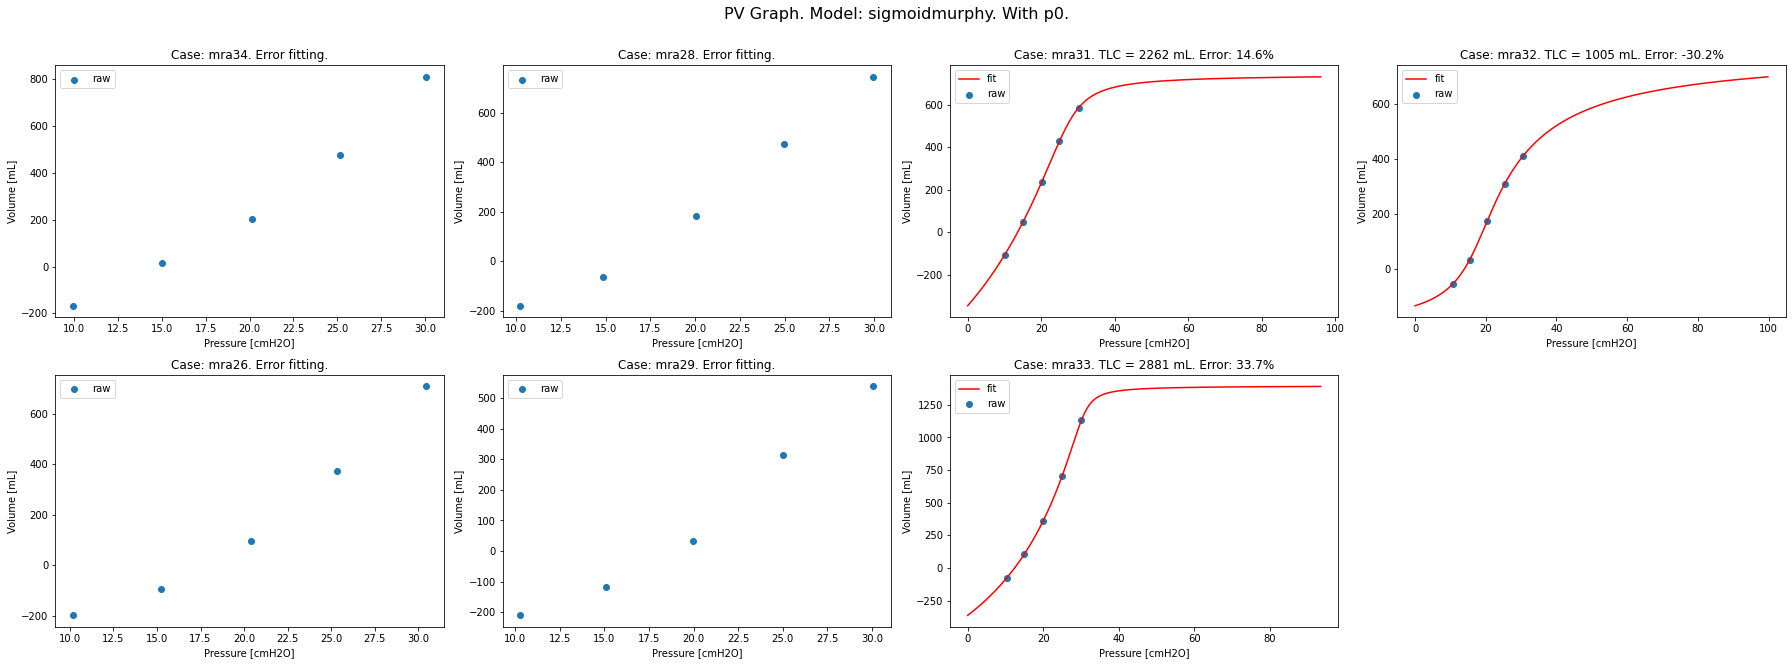

(156.5980084537746, 54.43431297203998, 5)

In [32]:
warnings.filterwarnings("ignore")
#warnings.filterwarnings("default")
n_points_interp = 0
texto = 'With p0.'
m.testa_modelo(dadosdfD5, modelo, metodo = metodo, meu_p0 = p0, texto = texto,
               TLC_index=TLC_index, n_points_interp=n_points_interp, debug=debug, invert_PV = invert_PV)

#### Entendendo parâmetros

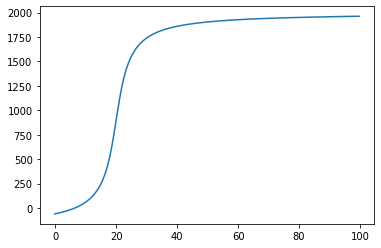

[6. 4.]


In [33]:
meu_p0 = [2000.0, -200.0, 3000.0, 3000.0, 20.0]
v_min,v_max = m.encontra_volumes_limites_Murphy(meu_p0)
meu_v = np.asarray(range(v_min,v_max))
meu_p = m.sigmoidmurphy(meu_v,*meu_p0)
plt.figure(figsize=(6,4)) # tamanho padrão (6,4)
plt.plot(meu_p,meu_v)
fig = plt.gcf()
plt.show()
size = fig.get_size_inches()#*fig.dpi # size in pixels
print(size)

In [34]:
m.encontra_volumes_limites_Murphy(meu_p0)

(-61, 1964)

# Testando vários

In [35]:
modelos = []

Vmin =  500 # mL
Vmax = 3500 # mL

# sigmoid_recruit_units:
#                 K, Vmax, mi, sigma, offset
mod = m.dados_modelos()
mod.model_function = m.sigmoid_recruit_units
mod.TLC_index = 1
mod.p0 =      [0.05, 2000, 25,     5,   -200]
mod.bounds = ([0.02, Vmin,  0,     2,   -500],
              [0.08, Vmax, 40,    40,    500])
modelos.append(mod)


# sigmoidvenegas1: (a, b, c, d): a + b/(1 + np.exp(-(x-c)/d))
#              offset, Vmax, 'mi', 'sigma'   
mod = m.dados_modelos()
mod.model_function = m.sigmoidvenegas1
mod.TLC_index = 1
mod.p0 =      [  -200, 2000,   25,      5]
mod.bounds = ([  -500, Vmin,    0,      2],
              [   500, Vmax,   40,     40])
modelos.append(mod)


# sigmoidpaivaoffset: (TLC,k1,k2,offset): TLC/(1+(k1*TCL*np.exp(-k2*x)))
#            Vmax,      k1,   k2, offset
mod = m.dados_modelos()
mod.model_function = m.sigmoidpaivaoffset
mod.TLC_index = 0
mod.p0 =      [  2000,   0.01, 0.05,   -200]
mod.bounds = ([  Vmin,      0,    0,   -500],
              [  Vmax,      1,   40,    500])
modelos.append(mod)


# sigmoidvenegas2offset: TLC,B,k,c,d: (TLC-(B*np.exp(-k*x)))/(1 + np.exp(-(x-c)/d)) + offset
#                Vmax,        B,       k,       c,       d,  offset
mod = m.dados_modelos()
mod.model_function = m.sigmoidvenegas2offset
mod.TLC_index = 0
mod.p0 =      [  2000,     0.01,    0.05,      10,       1,    -300]
mod.bounds = ([  Vmin,  -np.inf, -np.inf,       0, -np.inf,   -5000 ],
              [  Vmax,   np.inf,  np.inf,      40,  np.inf,    5000 ])
modelos.append(mod)


# sigmoidmurphy: VM,Vm,k1,k2,k3:
#                   VM,      Vm,      k1,      k2,      k3
mod = m.dados_modelos()
mod.model_function = m.sigmoidmurphy
mod.TLC_index = 0
mod.p0 =      [ 2000.0,  -200.0,  1000.0,  1000.0,    20.0]
mod.bounds = ([    500,    -500,     100,     100,    -100],
              [   3500,       0,  100000,  100000,     100])
mod.invert_PV = True
modelos.append(mod)


In [36]:
resultdf = m.testa_varios(dadosdfD5, modelos)

Rodando sigmoid_recruit_units
Rodando sigmoidvenegas1
Rodando sigmoidpaivaoffset
Rodando sigmoidvenegas2offset
Rodando sigmoidmurphy


In [37]:
resultdf.head(5)

,Modelo,Método,N_points_interp,Norma erro,Erro médio,n_fitted,|Erro médio|
0,sigmoid_recruit_units,lm,0,156.115391,54.956681,5,54.956681
1,sigmoid_recruit_units,trf,0,109.326363,38.056911,7,38.056911
2,sigmoid_recruit_units,dogbox,0,109.326362,38.056911,7,38.056911
3,sigmoid_recruit_units,lm,1,165.308331,56.538342,6,56.538342
4,sigmoid_recruit_units,trf,1,109.733407,38.188488,7,38.188488


In [38]:
# Pega só os casos em que todos os 7 dados foram fitados
resultdf_valid = resultdf[resultdf['n_fitted']==7].copy()

In [39]:
resultdf_valid

,Modelo,Método,N_points_interp,Norma erro,Erro médio,n_fitted,|Erro médio|
1,sigmoid_recruit_units,trf,0,109.326363,38.056911,7,38.056911
2,sigmoid_recruit_units,dogbox,0,109.326362,38.056911,7,38.056911
4,sigmoid_recruit_units,trf,1,109.733407,38.188488,7,38.188488
5,sigmoid_recruit_units,dogbox,1,109.733405,38.188487,7,38.188487
7,sigmoid_recruit_units,trf,2,109.723972,38.196342,7,38.196342
8,sigmoid_recruit_units,dogbox,2,109.723972,38.196342,7,38.196342
10,sigmoid_recruit_units,trf,10,109.596367,38.178016,7,38.178016
13,sigmoid_recruit_units,trf,20,109.559914,38.171001,7,38.171001
16,sigmoidvenegas1,trf,0,124.867076,45.868534,7,45.868534
19,sigmoidvenegas1,trf,1,124.903927,45.835516,7,45.835516


In [40]:
# Erro mínimo para cada modelo
resultdf_valid[['Modelo','Norma erro','|Erro médio|']].groupby('Modelo').min()

,Norma erro,|Erro médio|
Modelo,,
sigmoid_recruit_units,109.326362,38.056911
sigmoidmurphy,134.376432,43.523942
sigmoidpaivaoffset,124.089947,45.534258
sigmoidvenegas1,124.242940,45.577825
sigmoidvenegas2offset,124.734599,45.766289


In [41]:
# Erro médio para cada modelo
resultdf_valid[['Modelo','Norma erro','Erro médio']].groupby('Modelo').mean()

,Norma erro,Erro médio
Modelo,,
sigmoid_recruit_units,109.590470,38.154062
sigmoidmurphy,134.376432,43.523942
sigmoidpaivaoffset,124.562570,45.709476
sigmoidvenegas1,124.588470,45.716855
sigmoidvenegas2offset,138.350093,50.718137


In [42]:
dadosdfD5.head(3)

,Animal,Manobra,Dados,n_steps,Pressoes,Volumes,volume_esperado
0,mra33,D,"[[10.312239646911621, -75.62246704101562], [20...",5,"[10.312239646911621, 14.991406440734863, 20.00...","[-75.62246704101562, 107.81485748291016, 363.4...",2154.6
1,mra26,D,"[[10.178125381469727, -197.8517303466797], [20...",5,"[10.178125381469727, 15.212499618530273, 20.42...","[-197.8517303466797, -95.13343811035156, 97.13...",2622.9
2,mra32,D,"[[10.625260829925537, -53.54884338378906], [20...",5,"[10.625260829925537, 15.398958206176758, 20.37...","[-53.54884338378906, 33.332923889160156, 174.5...",1440.2


In [43]:
resultdf_indiv = m.testa_varios_indiv(dadosdfD5, modelos)

Rodando sigmoid_recruit_units
Rodando sigmoidvenegas1
Rodando sigmoidpaivaoffset
Rodando sigmoidvenegas2offset
Rodando sigmoidmurphy


In [44]:
resultdf_indiv

,Animal,Maneuver,n_steps,Pressures,Volumes,Model,Method,TLC_index,N_points_interp,p0,bounds,fitted,parameters,Vol_CT,error
0,mra33,D,5,"[10.312239646911621, 14.991406440734863, 20.00...","[-75.62246704101562, 107.81485748291016, 363.4...",sigmoid_recruit_units,lm,1,0,"[0.05, 2000, 25, 5, -200]",[],True,"[0.2950650830999958, 5010.634689847073, 40.335...",2154.6,132.555216
1,mra26,D,5,"[10.178125381469727, 15.212499618530273, 20.42...","[-197.8517303466797, -95.13343811035156, 97.13...",sigmoid_recruit_units,lm,1,0,"[0.05, 2000, 25, 5, -200]",[],True,"[0.3617384491338012, 1748.169559476714, 29.087...",2622.9,-33.349744
2,mra32,D,5,"[10.625260829925537, 15.398958206176758, 20.37...","[-53.54884338378906, 33.332923889160156, 174.5...",sigmoid_recruit_units,lm,1,0,"[0.05, 2000, 25, 5, -200]",[],True,"[0.013814478063350852, 1478.8270050759916, 16....",1440.2,2.682058
3,mra29,D,5,"[10.286250114440918, 15.094120502471924, 19.99...","[-210.43722534179688, -118.89096069335938, 33....",sigmoid_recruit_units,lm,1,0,"[0.05, 2000, 25, 5, -200]",[],True,"[0.4687231327416337, 932.3637637749814, 23.733...",2205.7,-57.729348
4,mra34,D,5,"[9.9609375, 15.040364742279053, 20.13463592529...","[-167.6243133544922, 13.06080150604248, 203.19...",sigmoid_recruit_units,lm,1,0,"[0.05, 2000, 25, 5, -200]",[],False,[],2600.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520,mra32,D,5,"[10.625260829925537, 15.398958206176758, 20.37...","[-53.54884338378906, 33.332923889160156, 174.5...",sigmoidmurphy,dogbox,0,20,"[2000.0, -200.0, 1000.0, 1000.0, 20.0]","([500, -500, 100, 100, -100], [3500, 0, 100000...",False,[],1440.2,0.000000
521,mra29,D,5,"[10.286250114440918, 15.094120502471924, 19.99...","[-210.43722534179688, -118.89096069335938, 33....",sigmoidmurphy,dogbox,0,20,"[2000.0, -200.0, 1000.0, 1000.0, 20.0]","([500, -500, 100, 100, -100], [3500, 0, 100000...",False,[],2205.7,0.000000
522,mra34,D,5,"[9.9609375, 15.040364742279053, 20.13463592529...","[-167.6243133544922, 13.06080150604248, 203.19...",sigmoidmurphy,dogbox,0,20,"[2000.0, -200.0, 1000.0, 1000.0, 20.0]","([500, -500, 100, 100, -100], [3500, 0, 100000...",False,[],2600.0,0.000000
523,mra28,D,5,"[10.240625381469727, 14.828125, 20.05937480926...","[-179.3195037841797, -62.187042236328125, 182....",sigmoidmurphy,dogbox,0,20,"[2000.0, -200.0, 1000.0, 1000.0, 20.0]","([500, -500, 100, 100, -100], [3500, 0, 100000...",False,[],2105.9,0.000000


,Animal,Maneuver,n_steps,Pressures,Volumes,Model,Method,TLC_index,N_points_interp,p0,bounds,fitted,parameters,Vol_CT,error
0,mra34,D,5,"[9.9609375, 15.040364742279053, 20.13463592529...","[-167.6243133544922, 13.06080150604248, 203.19...",sigmoid_recruit_units,lm,1,0,"[0.05, 2000, 25, 5, -200]",[],False,[],2600.0,0.000000
1,mra28,D,5,"[10.240625381469727, 14.828125, 20.05937480926...","[-179.3195037841797, -62.187042236328125, 182....",sigmoid_recruit_units,lm,1,0,"[0.05, 2000, 25, 5, -200]",[],False,[],2105.9,0.000000
2,mra31,D,5,"[10.0, 15.0, 20.100000381469727, 24.8999996185...","[-107.7169418334961, 47.35507583618164, 235.19...",sigmoid_recruit_units,lm,1,0,"[0.05, 2000, 25, 5, -200]",[],True,"[0.3428274099634894, 1017.4668485220444, 20.27...",1974.4,-48.467036
3,mra32,D,5,"[10.625260829925537, 15.398958206176758, 20.37...","[-53.54884338378906, 33.332923889160156, 174.5...",sigmoid_recruit_units,lm,1,0,"[0.05, 2000, 25, 5, -200]",[],True,"[0.013814478063350852, 1478.8270050759916, 16....",1440.2,2.682058
4,mra26,D,5,"[10.178125381469727, 15.212499618530273, 20.42...","[-197.8517303466797, -95.13343811035156, 97.13...",sigmoid_recruit_units,lm,1,0,"[0.05, 2000, 25, 5, -200]",[],True,"[0.3617384491338012, 1748.169559476714, 29.087...",2622.9,-33.349744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520,mra31,D,5,"[10.0, 15.0, 20.100000381469727, 24.8999996185...","[-107.7169418334961, 47.35507583618164, 235.19...",sigmoidmurphy,dogbox,0,20,"[2000.0, -200.0, 1000.0, 1000.0, 20.0]","([500, -500, 100, 100, -100], [3500, 0, 100000...",False,[],1974.4,0.000000
521,mra32,D,5,"[10.625260829925537, 15.398958206176758, 20.37...","[-53.54884338378906, 33.332923889160156, 174.5...",sigmoidmurphy,dogbox,0,20,"[2000.0, -200.0, 1000.0, 1000.0, 20.0]","([500, -500, 100, 100, -100], [3500, 0, 100000...",False,[],1440.2,0.000000
522,mra26,D,5,"[10.178125381469727, 15.212499618530273, 20.42...","[-197.8517303466797, -95.13343811035156, 97.13...",sigmoidmurphy,dogbox,0,20,"[2000.0, -200.0, 1000.0, 1000.0, 20.0]","([500, -500, 100, 100, -100], [3500, 0, 100000...",False,[],2622.9,0.000000
523,mra29,D,5,"[10.286250114440918, 15.094120502471924, 19.99...","[-210.43722534179688, -118.89096069335938, 33....",sigmoidmurphy,dogbox,0,20,"[2000.0, -200.0, 1000.0, 1000.0, 20.0]","([500, -500, 100, 100, -100], [3500, 0, 100000...",False,[],2205.7,0.000000


In [45]:
# Verificando quantos casos fitaram, por modelo
resultdf_indiv[['Model','fitted']].groupby('Model').describe()

fitted                   
                       count unique    top freq
Model                                          
sigmoid_recruit_units    105      2   True   95
sigmoidmurphy            105      2  False   55
sigmoidpaivaoffset       105      2   True   99
sigmoidvenegas1          105      2   True   99
sigmoidvenegas2offset    105      2   True   55

In [46]:
# pega só os que fitaram
resultdf_indiv_fitted = resultdf_indiv[resultdf_indiv['fitted']==True]

In [47]:
resultdf_indiv_fitted.head(3)

,Animal,Maneuver,n_steps,Pressures,Volumes,Model,Method,TLC_index,N_points_interp,p0,bounds,fitted,parameters,Vol_CT,error,Raw data
0,mra33,D,5,"[10.312239646911621, 14.991406440734863, 20.00...","[-75.62246704101562, 107.81485748291016, 363.4...",sigmoid_recruit_units,lm,1,0,"[0.05, 2000, 25, 5, -200]",[],True,"[0.2950650830999958, 5010.634689847073, 40.335...",2154.6,132.555216,"[[10.0, -107.7169418334961], [20.2000007629394..."
1,mra26,D,5,"[10.178125381469727, 15.212499618530273, 20.42...","[-197.8517303466797, -95.13343811035156, 97.13...",sigmoid_recruit_units,lm,1,0,"[0.05, 2000, 25, 5, -200]",[],True,"[0.3617384491338012, 1748.169559476714, 29.087...",2622.9,-33.349744,"[[10.625260829925537, -53.54884338378906], [20..."
2,mra32,D,5,"[10.625260829925537, 15.398958206176758, 20.37...","[-53.54884338378906, 33.332923889160156, 174.5...",sigmoid_recruit_units,lm,1,0,"[0.05, 2000, 25, 5, -200]",[],True,"[0.013814478063350852, 1478.8270050759916, 16....",1440.2,2.682058,"[[10.178125381469727, -197.8517303466797], [20..."


,Animal,Maneuver,n_steps,Pressures,Volumes,Model,Method,TLC_index,N_points_interp,p0,bounds,fitted,parameters,Vol_CT,error
2,mra31,D,5,"[10.0, 15.0, 20.100000381469727, 24.8999996185...","[-107.7169418334961, 47.35507583618164, 235.19...",sigmoid_recruit_units,lm,1,0,"[0.05, 2000, 25, 5, -200]",[],True,"[0.3428274099634894, 1017.4668485220444, 20.27...",1974.4,-48.467036
3,mra32,D,5,"[10.625260829925537, 15.398958206176758, 20.37...","[-53.54884338378906, 33.332923889160156, 174.5...",sigmoid_recruit_units,lm,1,0,"[0.05, 2000, 25, 5, -200]",[],True,"[0.013814478063350852, 1478.8270050759916, 16....",1440.2,2.682058
4,mra26,D,5,"[10.178125381469727, 15.212499618530273, 20.42...","[-197.8517303466797, -95.13343811035156, 97.13...",sigmoid_recruit_units,lm,1,0,"[0.05, 2000, 25, 5, -200]",[],True,"[0.3617384491338012, 1748.169559476714, 29.087...",2622.9,-33.349744


Text(0.5, 1.0, 'oi')

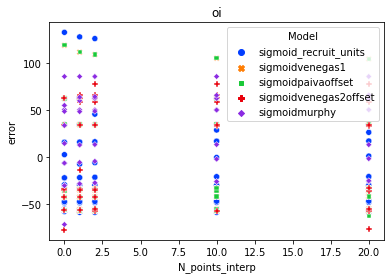

In [48]:
import seaborn as sns
sns.scatterplot(data=resultdf_indiv_fitted, x="N_points_interp", y="error", hue="Model",
                 palette='bright', 
                 style="Model").set_title('oi')

Text(0.5, 1.0, 'oi')

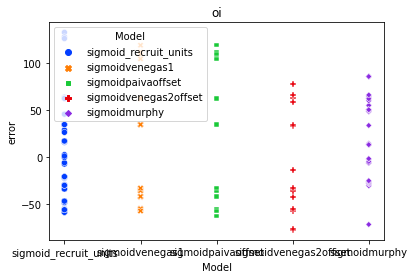

In [49]:
sns.scatterplot(data=resultdf_indiv_fitted, x="Model", y="error", hue="Model",
                 palette='bright', 
                 style="Model").set_title('oi')

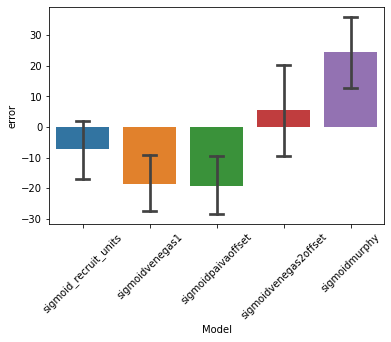

In [50]:
ax = sns.barplot(x="Model", y="error", data=resultdf_indiv_fitted, capsize=.2)
for item in ax.get_xticklabels():
    item.set_rotation(45)

In [51]:
resultdf_indiv_fitted[resultdf_indiv_fitted['Model']=='sigmoid_recruit_units']['error'].std()

46.034864346525076

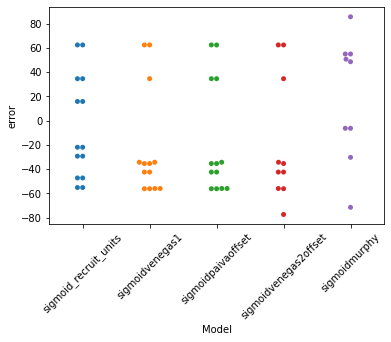

In [52]:
ax2 = sns.swarmplot(x="Model", y="error", data=resultdf_indiv_fitted[(resultdf_indiv_fitted['N_points_interp']==0) & (resultdf_indiv_fitted['Method']!='lm')])
for item in ax2.get_xticklabels():
    item.set_rotation(45)

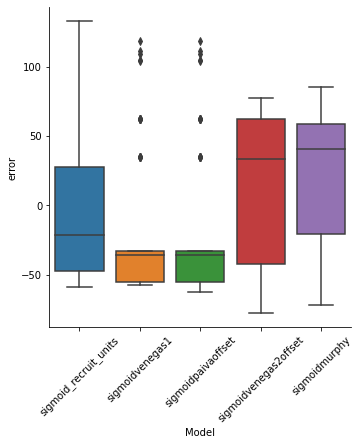

In [53]:
ax2 = sns.catplot(x="Model", y="error", kind="box", data=resultdf_indiv_fitted)
ax2.set_xticklabels(rotation=45)

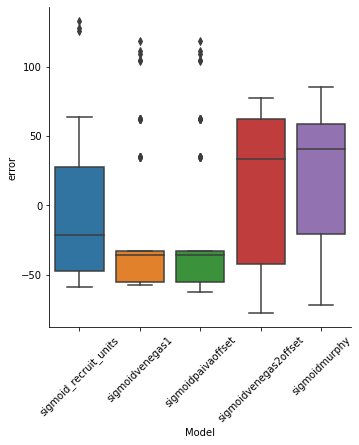

In [54]:
ax2 = sns.catplot(x="Model", y="error", kind="box", data=resultdf_indiv_fitted, whis = 1)
ax2.set_xticklabels(rotation=45)

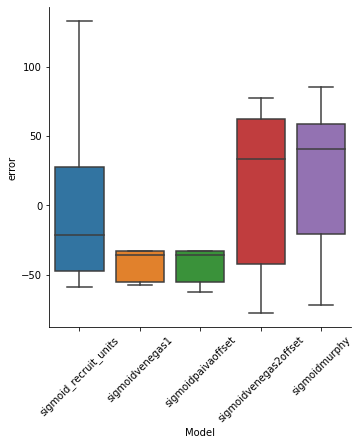

In [55]:
# para outliers, sem levar eles em consideração nas barras!
ax2 = sns.catplot(x="Model", y="error", kind="box", data=resultdf_indiv_fitted, showfliers = False)
ax2.set_xticklabels(rotation=45)

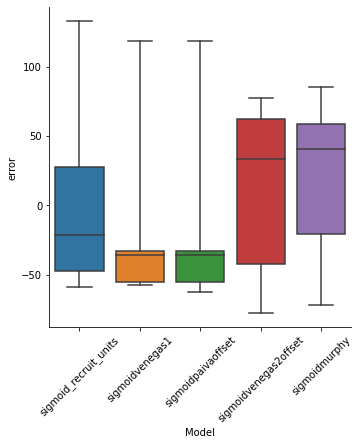

In [56]:
ax2 = sns.catplot(x="Model", y="error", kind="box", data=resultdf_indiv_fitted, whis = 10)
ax2.set_xticklabels(rotation=45)

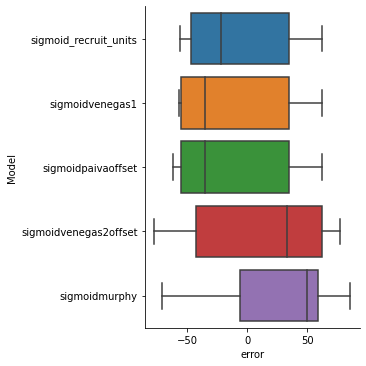

In [57]:
ax2 = sns.catplot(y="Model", x="error", kind="box", orient="h", data=resultdf_indiv_fitted[resultdf_indiv_fitted['Method']!='lm'])
#ax2.set_xticklabels(rotation=45)

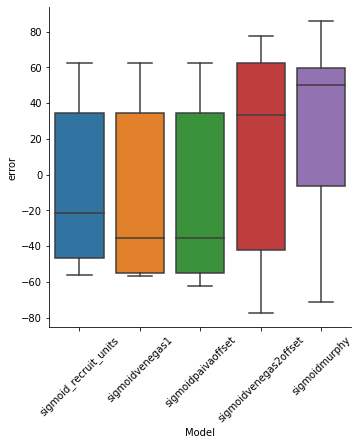

In [58]:
ax2 = sns.catplot(x="Model", y="error", kind="box", data=resultdf_indiv_fitted[resultdf_indiv_fitted['Method']!='lm'])
ax2.set_xticklabels(rotation=45)

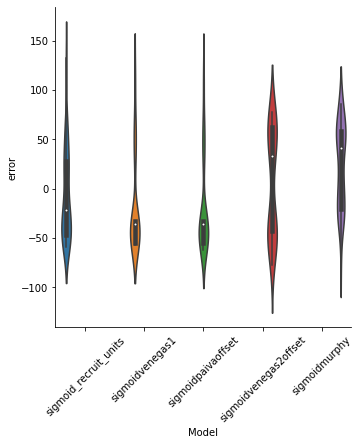

In [59]:
ax2 = sns.catplot(x="Model", y="error", hue="Model",
            kind="violin", data=resultdf_indiv_fitted)
ax2.set_xticklabels(rotation=45)

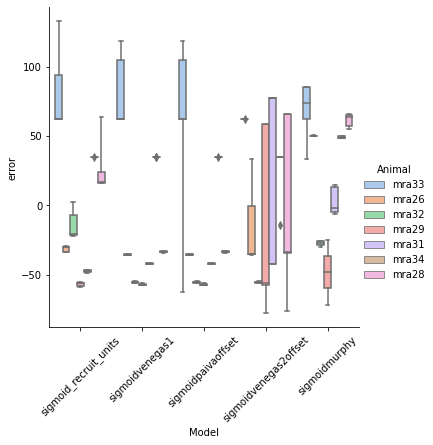

In [60]:
ax2 = sns.catplot(x="Model", y="error", hue="Animal", kind="box",
            palette="pastel", 
            data=resultdf_indiv_fitted, whis = 10)
ax2.set_xticklabels(rotation=45)

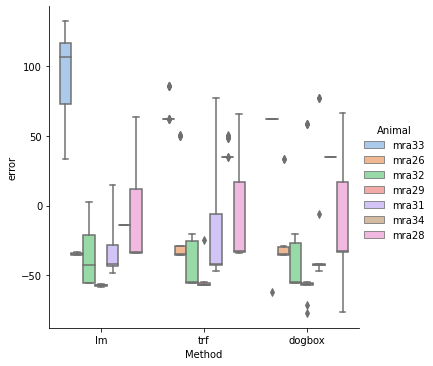

In [61]:
ax2 = sns.catplot(x="Method", y="error", hue="Animal", kind="box",
            palette="pastel", 
            data=resultdf_indiv_fitted, whis = 10)
#ax2.set_xticklabels(rotation=45)

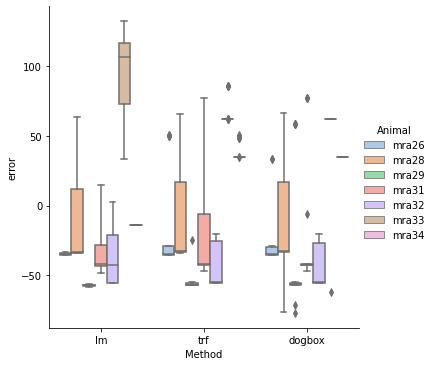

In [62]:
ax2 = sns.catplot(x="Method", y="error", hue="Animal", kind="box",
            palette="pastel", 
            data=resultdf_indiv_fitted, whis = 10,
            hue_order=('mra26','mra28','mra29','mra31','mra32','mra33','mra34'))
#ax2.set_xticklabels(rotation=45)

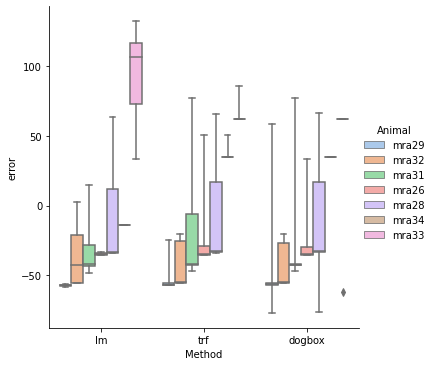

In [63]:
ax2 = sns.catplot(x="Method", y="error", hue="Animal", kind="box",
            palette="pastel",  whis = np.inf,
            data=resultdf_indiv_fitted,
            hue_order=('mra29','mra32','mra31','mra26','mra28','mra34','mra33'))
#ax2.set_xticklabels(rotation=45)

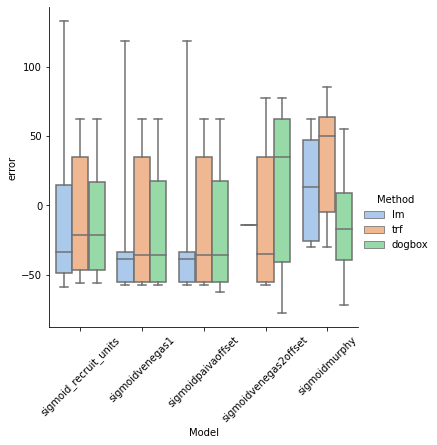

In [64]:
ax2 = sns.catplot(x="Model", y="error", hue="Method", kind="box",
            palette="pastel", 
            data=resultdf_indiv_fitted, whis = 10)
ax2.set_xticklabels(rotation=45)

In [65]:
resultdf_indiv_fitted.head(3)

,Animal,Maneuver,n_steps,Pressures,Volumes,Model,Method,TLC_index,N_points_interp,p0,bounds,fitted,parameters,Vol_CT,error,Raw data
0,mra33,D,5,"[10.312239646911621, 14.991406440734863, 20.00...","[-75.62246704101562, 107.81485748291016, 363.4...",sigmoid_recruit_units,lm,1,0,"[0.05, 2000, 25, 5, -200]",[],True,"[0.2950650830999958, 5010.634689847073, 40.335...",2154.6,132.555216,"[[10.0, -107.7169418334961], [20.2000007629394..."
1,mra26,D,5,"[10.178125381469727, 15.212499618530273, 20.42...","[-197.8517303466797, -95.13343811035156, 97.13...",sigmoid_recruit_units,lm,1,0,"[0.05, 2000, 25, 5, -200]",[],True,"[0.3617384491338012, 1748.169559476714, 29.087...",2622.9,-33.349744,"[[10.625260829925537, -53.54884338378906], [20..."
2,mra32,D,5,"[10.625260829925537, 15.398958206176758, 20.37...","[-53.54884338378906, 33.332923889160156, 174.5...",sigmoid_recruit_units,lm,1,0,"[0.05, 2000, 25, 5, -200]",[],True,"[0.013814478063350852, 1478.8270050759916, 16....",1440.2,2.682058,"[[10.178125381469727, -197.8517303466797], [20..."


,Animal,Maneuver,n_steps,Pressures,Volumes,Model,Method,TLC_index,N_points_interp,p0,bounds,fitted,parameters,Vol_CT,error
2,mra31,D,5,"[10.0, 15.0, 20.100000381469727, 24.8999996185...","[-107.7169418334961, 47.35507583618164, 235.19...",sigmoid_recruit_units,lm,1,0,"[0.05, 2000, 25, 5, -200]",[],True,"[0.3428274099634894, 1017.4668485220444, 20.27...",1974.4,-48.467036
3,mra32,D,5,"[10.625260829925537, 15.398958206176758, 20.37...","[-53.54884338378906, 33.332923889160156, 174.5...",sigmoid_recruit_units,lm,1,0,"[0.05, 2000, 25, 5, -200]",[],True,"[0.013814478063350852, 1478.8270050759916, 16....",1440.2,2.682058
4,mra26,D,5,"[10.178125381469727, 15.212499618530273, 20.42...","[-197.8517303466797, -95.13343811035156, 97.13...",sigmoid_recruit_units,lm,1,0,"[0.05, 2000, 25, 5, -200]",[],True,"[0.3617384491338012, 1748.169559476714, 29.087...",2622.9,-33.349744


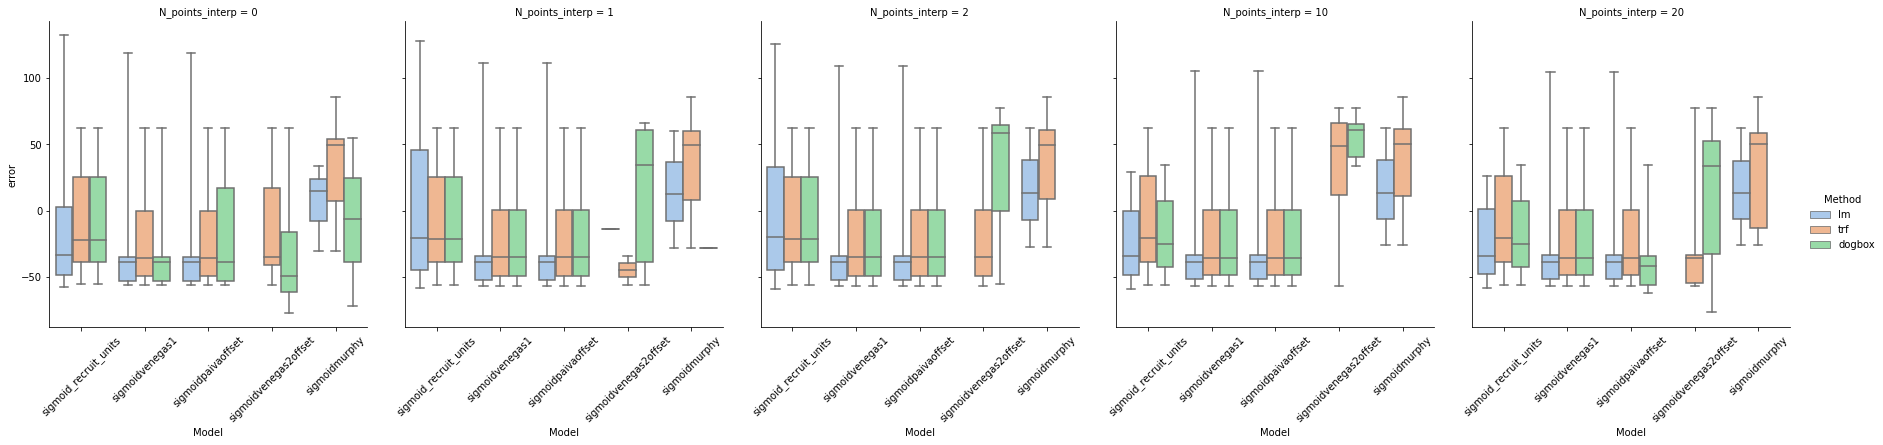

In [66]:
ax2 = sns.catplot(x="Model", y="error", hue="Method", kind="box",
            palette="pastel", col="N_points_interp",
            data=resultdf_indiv_fitted, whis = 10)
ax2.set_xticklabels(rotation=45)

In [67]:
def add_margin(ax,x=0.05,y=0.05):
    # This will, by default, add 5% to the x and y margins. You 
    # can customise this using the x and y arguments when you call it.

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xmargin = (xlim[1]-xlim[0])*x
    ymargin = (ylim[1]-ylim[0])*y

    ax.set_xlim(xlim[0]-xmargin,xlim[1]+xmargin)
    ax.set_ylim(ylim[0]-ymargin,ylim[1]+ymargin)

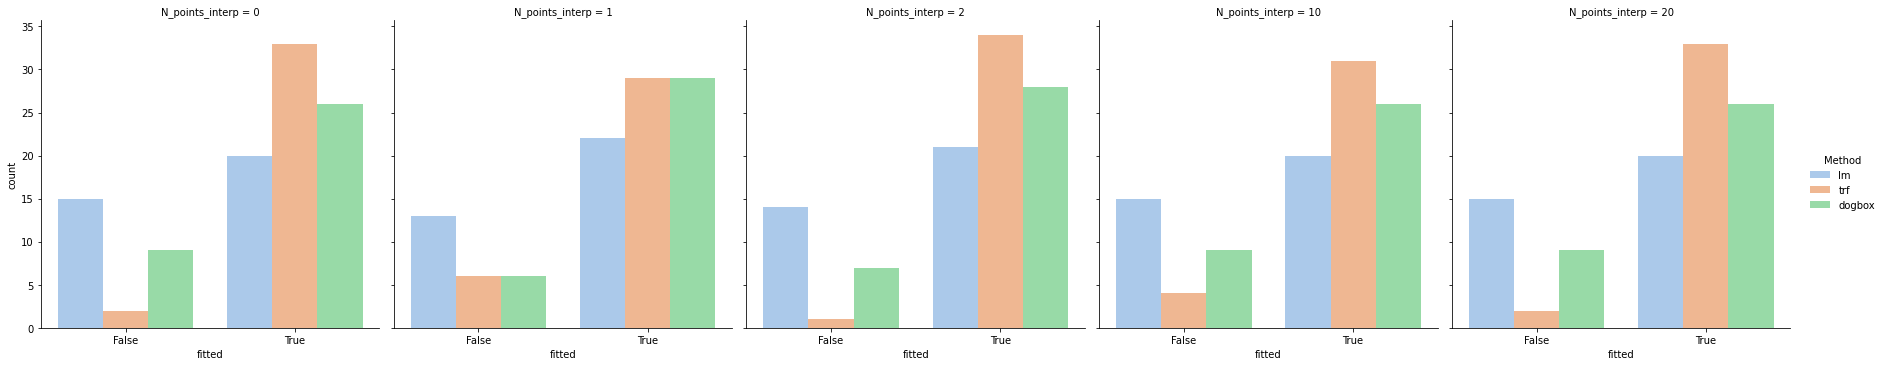

In [68]:
ax2 = sns.catplot(x="fitted", kind="count", hue='Method',
            palette="pastel", col="N_points_interp",
            data=resultdf_indiv)
#ax2.set_xticklabels(rotation=45)


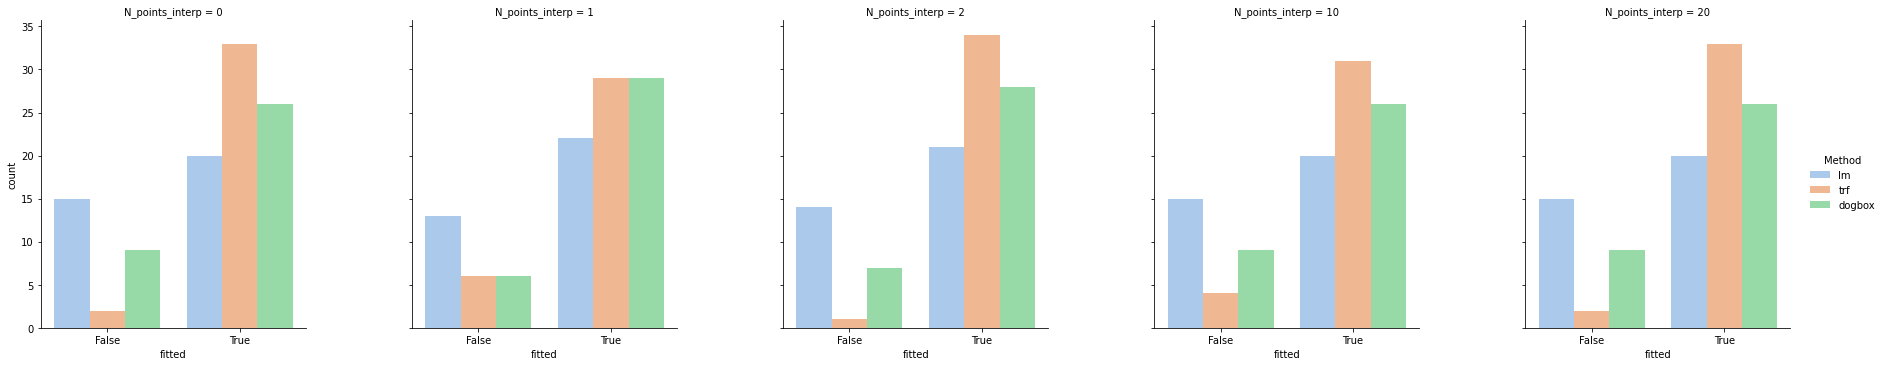

In [69]:
ax2 = sns.catplot(x="fitted", kind="count", hue='Method',
            palette="pastel", col="N_points_interp",
            data=resultdf_indiv)
plt.subplots_adjust(hspace=0.4, wspace=0.4)

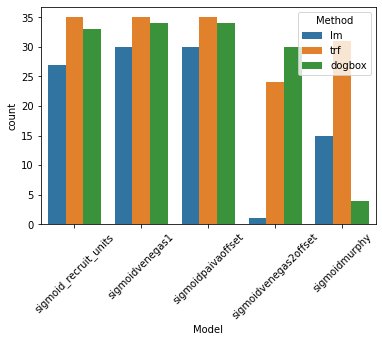

In [70]:
ax = sns.countplot(x="Model", hue="Method",
                   data=resultdf_indiv_fitted)
for item in ax.get_xticklabels():
    item.set_rotation(45)

In [71]:
resultdf_indiv_fitted.groupby('Model').count()

,Animal,Maneuver,n_steps,Pressures,Volumes,Method,TLC_index,N_points_interp,p0,bounds,fitted,parameters,Vol_CT,error,Raw data
Model,,,,,,,,,,,,,,,
sigmoid_recruit_units,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95
sigmoidmurphy,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50
sigmoidpaivaoffset,99,99,99,99,99,99,99,99,99,99,99,99,99,99,99
sigmoidvenegas1,99,99,99,99,99,99,99,99,99,99,99,99,99,99,99
sigmoidvenegas2offset,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55


In [72]:
resultdf_indiv_fitted.groupby('Model').count()

,Animal,Maneuver,n_steps,Pressures,Volumes,Method,TLC_index,N_points_interp,p0,bounds,fitted,parameters,Vol_CT,error,Raw data
Model,,,,,,,,,,,,,,,
sigmoid_recruit_units,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95
sigmoidmurphy,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50
sigmoidpaivaoffset,99,99,99,99,99,99,99,99,99,99,99,99,99,99,99
sigmoidvenegas1,99,99,99,99,99,99,99,99,99,99,99,99,99,99,99
sigmoidvenegas2offset,55,55,55,55,55,55,55,55,55,55,55,55,55,55,55


# Testes

In [73]:
# CUIDADO COM VARIÁVEIS COMPARTILHADAS NA CLASSE!!!
class TempClass():
    flag = True  # variável única para cada instância
    vec = []     # lista compartilhada por toda a classe

In [74]:
t1 = TempClass()
print(f'{t1.flag} {t1.vec}')
t1.flag = False
t1.vec.append('a')
print(f'{t1.flag} {t1.vec}')


True []
False ['a']


In [75]:
t2 = TempClass()
print(f'{t1.flag} {t1.vec}')
print(f'{t2.flag} {t2.vec}')


False ['a']
True ['a']


In [76]:
id(t2.vec) == id(t1.vec)

True

In [77]:
id(t1.vec)

139751652600832

In [ ]:
t3 = TempClass()
t3.vec = 'oi'
print(f'{t1.flag} {t1.vec}')
print(f'{t2.flag} {t2.vec}')
t3.fruta='banana' # é possível criar itens que não pertencem à classe!
print(f'{t3.flag} {t3.vec} {t3.fruta}')


False ['a']
True ['a']
True oi banana


In [79]:
id(t2.vec) == id(t3.vec)

False

In [ ]:
result = np.array([[2,3],[2,2],[1,1]])
len(result)

3